<a href="https://colab.research.google.com/github/BrunoLad/tcc-ufabc/blob/main/tcc_ufabc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Informações de recurso da máquina disponibilizada no colab

In [ ]:
!df -h
!cat /proc/cpuinfo
!cat /proc/meminfo

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   23G   86G  21% /
tmpfs            64M     0   64M   0% /dev
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G  1.1G  910M  54% /sbin/docker-init
tmpfs           6.4G   32K  6.4G   1% /var/colab
/dev/sda1        41G   24G   17G  59% /etc/hosts
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc 

## Monta o google drive para permitir a leitura dos dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Instalando o Stanza - Wrapper do Stanford CoreNLP para python e demais bibliotecas para manipulação e visualização

> É possível instalar o próprio NLTK que possui referência para o Stanford CoreNLP, porém o stanza é o [recomendado](https://stanfordnlp.github.io/CoreNLP/other-languages.html#official-stanza-package-by-the-stanford-nlp-group).

In [ ]:
!python -m pip install -U pip
!pip install stanza -U
# !pip install matplotlib
!pip install matplotlib==3.6.2
# !python -m pip install -U matplotlib
!pip install pandas
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.3/691.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=877ab7f6b7ae3599419f2ad2c7b46153359ed2f99b76b3351699584b4886a428
  Stored in directory: /root/.cache/pip/wheels/39/08/a1/b0bb1f7683d20b75b34ceeb56ee83a585e9b065a5fef0b2cb1
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Monta lista de classes de interesse para utilização durante o processamento

In [ ]:
from enum import Enum
import re

class BookInfo:
  def __init__(self, file_name):
    pattern = r'(.+)(?:___)(.+)\.txt'
    book_regex = re.compile(pattern)
    self.filename = file_name
    self.author = Author(book_regex.match(file_name).group(1))
    self.title = book_regex.match(file_name).group(2)
    self.bookid = None
    self.metadata = None

class Author:
  def __init__(self, name):
    self.name = name
    self.gender = None
  
  def add_gender(self, gender):
    self.gender = gender.value

class Gender(Enum):
  FEMALE = 'F'
  MALE = 'M'

class AnalysisResult:
  def __init__(self, book):
    self.book = book
    self.adjectives = dict.fromkeys([Gender.MALE, Gender.FEMALE])
    self.verbs = dict.fromkeys([Gender.MALE, Gender.FEMALE])
    self.occupations = dict.fromkeys([Gender.MALE, Gender.FEMALE])
    self.mentions = dict.fromkeys([Gender.MALE, Gender.FEMALE])
    self.characters = dict.fromkeys([Gender.MALE, Gender.FEMALE])

# Realiza o filtro dos livros que são de ficção
O filtro ocorre da seguinte forma:
Uma classe BookInfo é definida, que contém as propriedades do nome do arquivo (para obtenção do texto para análise posterior), uma ref pra class autor que contém nome e gênero do autor (para categorização posterior), título da obra (para identificação), id do livro (para obtenção dos metadados do livro e filtragem dos livros que são de ficção)

In [ ]:
import os
import re
import json
from enum import Enum

# Necessário tratar os casos em que o nome do autor encontra-se na
# linha posterior ao título da obra
def extract_line_from_file(file_name, book):
  with open(file_name, 'r') as read_obj:
    for line in read_obj:
      if book.title in line and book.author.name in line:
        return line
  return ''

if __name__ == '__main__':
  BOOKS_HOME = '/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/txt'
  gutenberg_metadata_file = open('/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/gutenberg-metadata.json')
  gutenberg_metadata = json.load(gutenberg_metadata_file)

  pattern = r'[^_]*$'
  digitPattern = r'\d+'
  re_bookId = re.compile(digitPattern, re.MULTILINE)
  regex = re.compile(pattern, re.MULTILINE)
  fileList = os.listdir(BOOKS_HOME)
  newBooks = map(lambda book: BookInfo(book), fileList)
  newBooksList = list(newBooks)
  print(len(newBooksList))
  
  for book in newBooksList:
    line = extract_line_from_file('/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/GUTINDEX.ALL06072021.txt', book)
    match = re_bookId.search(line)
    if match:
      book.bookid = match.group()
      book.metadata = gutenberg_metadata.get(book.bookid)
      
  filteredBooks = list(filter(lambda book: book.bookid is not None, newBooksList))
  # Fiction + Short stories + Children's stories (or just child) ?
  fiction_books = filter(lambda book: book.bookid in gutenberg_metadata and re.search(r'[fF]iction', json.dumps(gutenberg_metadata[book.bookid]['subject'])), filteredBooks)
  fiction_books_list = list(fiction_books)
  print(len(fiction_books_list))

  for book in fiction_books_list:
    print('{0}: {1} by {2}'.format(book.bookid, book.title, book.author.name))

  for book in fiction_books_list:
    print(book.metadata)

3036
894
31516: The Eyes Have It by Philip Kindred Dick
28554: Beyond Lies the Wub by Philip Kindred Dick
32032: Second Variety by Philip Kindred Dick
28698: The Crystal Crypt by Philip Kindred Dick
2389: Bardelys the Magnificent by Rafael Sabatini
28944: Captain Blood by Rafael Sabatini
1457: Mistress Wilding by Rafael Sabatini
23493: Under the Waves by R M Ballantyne
3530: Love-at-Arms by Rafael Sabatini
2640: St. Martin's Summer by Rafael Sabatini
28945: Scaramouche by Rafael Sabatini
2687: The Snare by Rafael Sabatini
2783: The Trampling of the Lilies by Rafael Sabatini
2636: The Historical Nights' Entertainment, First Series by Rafael Sabatini
3030: The Tavern Knight by Rafael Sabatini
2702: The Lion's Skin by Rafael Sabatini
14133: David Balfour, Second Part by Robert Louis Stevenson
589: Catriona by Robert Louis Stevenson
329: Island Nights' Entertainments by Robert Louis Stevenson
344: Fables by Robert Louis Stevenson
56562: Kidnapped by Robert Louis Stevenson
839: New Arabian 

# Pega lista de livros já tratados

In [ ]:
import os
from heapq import nsmallest

if __name__ == '__main__':
  # n = 200
  file_list = os.listdir('/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/cleaned')
  # smallest = nsmallest(n, file_list, lambda x: os.stat('/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/cleaned/' + x).st_size)
  # print(smallest)
  print(file_list)
  newBooks = map(lambda book: BookInfo(book), file_list)
  fiction_books_list = list(newBooks)
  print(len(fiction_books_list))



['Anthony Trollope___Rachel Ray.txt', 'Philip Kindred Dick___The Eyes Have It.txt', 'Philip Kindred Dick___Beyond Lies the Wub.txt', 'Philip Kindred Dick___Second Variety.txt', 'Philip Kindred Dick___The Crystal Crypt.txt', 'Rafael Sabatini___Bardelys the Magnificent.txt', 'Rafael Sabatini___Captain Blood.txt', 'Rafael Sabatini___Mistress Wilding.txt', 'R M Ballantyne___Under the Waves.txt', 'Rafael Sabatini___Love-at-Arms.txt', "Rafael Sabatini___St. Martin's Summer.txt", 'Rafael Sabatini___Scaramouche.txt', 'Rafael Sabatini___The Snare.txt', 'Rafael Sabatini___The Trampling of the Lilies.txt', "Rafael Sabatini___The Historical Nights' Entertainment, First Series.txt", 'Rafael Sabatini___The Tavern Knight.txt', "Rafael Sabatini___The Lion's Skin.txt", 'Robert Louis Stevenson___David Balfour, Second Part.txt', 'Robert Louis Stevenson___Catriona.txt', "Robert Louis Stevenson___Island Nights' Entertainments.txt", 'Robert Louis Stevenson___Fables.txt', 'Robert Louis Stevenson___Kidnapped.

# Copia os livros de ficção para uma nova pasta para futuras manipulações
Move os livros para uma nova posta chamada **fiction** para que possa ser manipulado futuramente, deixando o corpus original intacto.

In [ ]:
from shutil import copyfile
import shutil
from pathlib import Path
import os

print(os.listdir())


FICTION_BOOKS_HOME = '/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/fiction'
CLEANED_BOOKS_HOME = '/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/cleaned'
PROCESSED_BOOKS_PATH = '/content/drive/MyDrive/TCC/unprocessed'
processed_path = Path(PROCESSED_BOOKS_PATH)

books_processed = os.listdir('/content/drive/MyDrive/TCC/results')
print(f'The amount of total processed books was {len(books_processed)}')
books_processed = set(map(lambda x: re.sub('pickle', 'txt', x), books_processed))

fileList = os.listdir(f'{CLEANED_BOOKS_HOME}/')
newBooks = map(lambda book: BookInfo(book), fileList)
fiction_books_list = list(newBooks)
fiction_books_list = list(filter(lambda x: x.filename not in books_processed, fiction_books_list))
print(len(fiction_books_list))

# Remove a pasta e todo seu conteúdo caso ela já existia
# E Cria a pasta do zero
if processed_path.exists():
  shutil.rmtree(processed_path)
  # [f.unlink() for f in cleaned_path.itedir() if f.is_file()]
  # cleaned_path.rmdir()

processed_path.mkdir(parents = True, exist_ok = True)

for book in fiction_books_list:
  copyfile(CLEANED_BOOKS_HOME + '/' + book.filename, PROCESSED_BOOKS_PATH + '/' + book.filename)

['.config', 'drive', 'sample_data']
The amount of total processed books was 390
504


# Limpa os livros
Faz várias limpezas nos livros obtidos inplace (no mesmo arquivo que foi aberto e já inserido no diretório de livros de ficção), tanto a fim de aumentar a acurácia, quanto a fim de diminuir o tamanho dos livros com o intuito de otimizar o tempo de análise.

As limpezas efetuadas são:
- Transforma todos os whitespaces no mesmo tipo ' '
- Remove todos os dados antes do primeiro capitulos, nos livros que possuem o padrao:
  - Chapter [1I]
- Pega todo o conteúdo depois do separador 'by nomeAutor'
- Subsitui algarismos romanos por outra delimitador mais fácil de remover e depois remove linhas que iniciem com este delimitador que foi inserido
- Transforma o sinal tironiano num 'and' normal da língua inglesa
- Remove o nome do autor caso encontrado no livro
- Remove o título da obra caso encontrado no livro
- Remove espaços e quebras de linha em excesso

In [ ]:
import os
import re

CLEANED_BOOKS_HOME = '/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/cleaned'
# roman_pattern = """(M{1,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})|M{0,4}(CM|C?D|D?C{1,3})(XC|XL|L?X{0,3})\
# (IX|IV|V?I{0,3})|M{0,4}(CM|CD|D?C{0,3})(XC|X?L|L?X{1,3})(IX|IV|V?I{0,3})|M{0,4}(CM|CD|D?C{0,3})\
# (XC|XL|L?X{0,3})(IX|I?V|V?I{1,3}))"""
# Pattern adapted from https://www.oreilly.com/library/view/regular-expressions-cookbook/9780596802837/
chapter_pattern = "Chapter (\d+|(?=[MDCLXVI])M*(C[MD]|D?C{0,3})(X[CL]|L?X{0,3})(I[XV]|V?I{0,3}))\..*$"
roman_pattern = "(?=[MDCLXVI])M*(C[MD]|D?C{0,3})(X[CL]|L?X{0,3})(I[XV]|V?I{0,3})\b\..*$"
loose_roman_pattern = "\b((?=[MDCLXV]|[I]{2,3})M*(C[MD]|D?C{0,3})(X[CL]|L?X{0,3})(V?I{0,3}))\b|\bIV\b|\bIX\b"

# Atualiza o livro (objeto do tipo arquivo, aberto na localização daquele livro)
# com o content passado
def update_book_data(book_file, content):
  book_file.seek(0)
  book_file.write(content)
  book_file.truncate()

# Elimina "impurezas" do corpo do livro
def clean_book(book):
  # with open(f'{FICTION_BOOKS_HOME}/{book.filename}', r) as bookfile:
  with open(f'{CLEANED_BOOKS_HOME}/{book.filename}', 'r+') as bookfile:
    book_content = bookfile.read()
    
    # Transforma todos os whitespaces no mesmo tipo
    # book_content = re.sub(r'\s', ' ', book_content)

    # Remove todos os dados antes do primeiro capitulo, nos livros que possuem o padrao
    # Chapter [1I]
    # book_content = re.sub(r"contents(\s*\w\.*'*)*\s{2}", '', book_content, flags = re.IGNORECASE | re.MULTILINE)
    content = re.split(r'chapter [i1]\.', book_content, flags = re.IGNORECASE | re.MULTILINE)
    book_content = content[1] if len(content) > 1 else content[0]

    # Pega todo o conteudo depois do separador 'by {authorName}'
    content = re.split(fr'by\s+{book.author.name}$', book_content, flags = re.IGNORECASE | re.MULTILINE)
    book_content = ''.join(content[1:]) if len(content) > 1 else content[0]
    
    # Remove Illustrations indicator
    book_content = re.sub(r'\[Illustration\w*\]', '', book_content, flags = re.IGNORECASE | re.MULTILINE)

    # # Remove indicativos de capítulos com algarismos romanos
    # book_content = re.sub(fr'{roman_pattern}', '', book_content, flags = re.IGNORECASE | re.MULTILINE)

    # Remove linhas com capítulo no formato Chapter I1.
    book_content = re.sub(fr'{chapter_pattern}', '', book_content, flags = re.IGNORECASE | re.MULTILINE)
    
    # # Subsitui algarismos romanos por outra delimitador mais fácil de remover
    # # Depois remova linhas que iniciem com este delimitador que foi inserido
    # book_content = re.sub(fr'{loose_roman_pattern}', '%%%%%', book_content, flags = re.IGNORECASE | re.MULTILINE)
    # book_content = re.sub(r'^(%{5}.*)$', '', book_content, flags = re.IGNORECASE | re.MULTILINE)


    # Transforma o sinal tironiano num 'and' normal da língua inglesa
    # para facilitar o processamento do texto
    book_content = re.sub(r'&', 'and', book_content)
    # Remove o nome do autor caso encontrado no livro
    book_content = re.sub(book.author.name, '', book_content, re.IGNORECASE)
    # Remove o título da obra caso encontrado no livro
    # book_content = re.sub(book.title, '', book_content, re.IGNORECASE)

    # Remove espaços e quebras de linha em excesso
    book_content = re.sub(r'\s+', ' ', book_content)

    update_book_data(bookfile, book_content)

fileList = os.listdir(f'{CLEANED_BOOKS_HOME}/')
newBooks = map(lambda book: BookInfo(book), fileList)
cleaned_books_list = list(newBooks)
print(len(cleaned_books_list))
  
for book in cleaned_books_list:
  clean_book(book)



894


# Lista de gênero dos autores [manualmente construído](https://docs.google.com/spreadsheets/d/17SkiDRPUTHVQLvM4FjEJjM_mdcdwqMiI4j3QYGxZfh4/edit#gid=544847314) e delimitação dos livros escolhidos para análise

In [ ]:
books_processed = os.listdir('/content/drive/MyDrive/TCC/results')
print(f'The amount of total processed books was {len(books_processed)}')
books_processed = set(map(lambda x: re.sub('pickle', 'txt', x), books_processed))

books_to_exclude = {
  r"Anthony Trollope___Ayala's Angel.txt", "Anthony Trollope___Barchester Towers.txt",
  'Abraham Lincoln___Speeches and Letters of Abraham Lincoln, 1832-1865.txt', 'Anthony Trollope___Can You Forgive Her?.txt',
  'Anthony Trollope___Castle Richmond.txt', 'Anthony Trollope___Doctor Thorne.txt', 'Anthony Trollope___Framley Parsonage.txt',
  'Anthony Trollope___He Knew He Was Right.txt', 'Anthony Trollope___Is He Popenjoy?.txt', 'Bret Harte___A First Family of Tasajara.txt',
  'Bret Harte___Cressy.txt', 'Bret Harte___From Sand Hill to Pine.txt', 'Charles Dickens___A Tale of Two Cities.txt',
  'Charles Dickens___David Copperfield.txt', 'Charles Dickens___Great Expectations.txt', 'Charles Dickens___Hard Times.txt',
  'Charlotte Bronte___Jane Eyre.txt', 'Charlotte Bronte___Villette.txt', 'Charlotte Mary Yonge___Modern Broods.txt',
  'Charlotte Mary Yonge___The Two Guardians.txt', 'Daniel Defoe___The King of Pirates.txt', 'James Otis___Richard of Jamestown.txt',
  'Ambrose Bierce___Can Such Things Be?.txt', 'Andrew Lang___A Monk of Fife.txt', 'Andrew Lang___In the Wrong Paradise.txt',
  'Andrew Lang___The Disentanglers.txt', 'Andrew Lang___The Mark Of Cain.txt', 'Anthony Trollope___Dr. Wortle\'s School.txt',
  'Anthony Trollope___John Caldigate.txt', 'Anthony Trollope___Lady Anna.txt', 'Anthony Trollope___Linda Tressel.txt',
  'Anthony Trollope___Marion Fay.txt', 'Anthony Trollope___Miss Mackenzie.txt', 'Anthony Trollope___Mr. Scarborough\'s Family.txt',
  'Anthony Trollope___Nina Balatka.txt', 'Anthony Trollope___Orley Farm.txt', 'Anthony Trollope___Phineas Finn.txt',
  'Anthony Trollope___Phineas Redux.txt', 'Anthony Trollope___Rachel Ray.txt', 'Anthony Trollope___Ralph the Heir.txt',
  'Anthony Trollope___Sir Harry Hotspur of Humblethwaite.txt', 'Anthony Trollope___The American Senator.txt',
  'Anthony Trollope___The Belton Estate.txt', 'Anthony Trollope___The Bertrams.txt', 'Anthony Trollope___The Claverings.txt',
  'Anthony Trollope___The Duke\'s Children.txt', 'Anthony Trollope___The Eustace Diamonds.txt', 'Anthony Trollope___The Fixed Period.txt',
  'Anthony Trollope___The Kellys and the O\'Kellys.txt', 'Anthony Trollope___The Landleaguers.txt', 'Anthony Trollope___The Last Chronicle of Barset.txt',
  'Anthony Trollope___The Macdermots of Ballycloran.txt', 'Anthony Trollope___The Prime Minister.txt', 'Anthony Trollope___The Small House at Allington.txt',
  'Anthony Trollope___The Three Clerks.txt', 'Anthony Trollope___The Vicar of Bullhampton.txt', 'Anthony Trollope___The Warden.txt',
  'Anthony Trollope___The Way We Live Now.txt', 'Benjamin Disraeli___Alroy.txt', 'Benjamin Disraeli___Coningsby.txt',
  'Benjamin Disraeli___Endymion.txt', 'Benjamin Disraeli___Henrietta Temple.txt', 'Benjamin Disraeli___Lothair.txt',
  'Benjamin Disraeli___Sybil.txt', 'Benjamin Disraeli___Tancred.txt', 'Benjamin Disraeli___The Young Duke.txt', 'Benjamin Disraeli___Venetia.txt',
  'Benjamin Disraeli___Vivian Grey.txt', 'Bram Stoker___Dracula.txt', 'Bram Stoker___Dracula\'s Guest.txt', 'Bram Stoker___The Jewel of Seven Stars.txt',
  'Bram Stoker___The Lady of the Shroud.txt', 'Bram Stoker___The Man.txt', 'Bret Harte___A Protegee of Jack Hamlin\'s and Other Stories.txt',
  'Bret Harte___A Sappho of Green Springs.txt', 'Bret Harte___Clarence.txt', 'Bret Harte___Drift from Two Shores.txt', 'Bret Harte___Openings in the Old Trail.txt',
  'Bret Harte___Sally Dows and Other Stories.txt', 'Bret Harte___Selected Stories.txt', 'Bret Harte___Stories in Light and Shadow.txt',
  'Bret Harte___Susy, A Story of the Plains.txt', 'Bret Harte___Tales of Trail and Town.txt', 'Bret Harte___Tales of the Argonauts.txt',
  'Bret Harte___Frontier Stories.txt', 'Bret Harte___The Bell-Ringer of Angel\'s and Other Stories.txt', 'Bret Harte___The Crusade of the Excelsior.txt',
  'Bret Harte___The Heritage of Dedlow Marsh and Other Tales.txt', 'Bret Harte___The Luck of Roaring Camp and Other Tales.txt', 'Bret Harte___The Three Partners.txt',
  'Bret Harte___Trent\'s Trust and Other Stories.txt', 'Bret Harte___Under the Redwoods.txt', 'Charles Dickens___Barnaby Rudge.txt',
  'Charles Dickens___Bleak House.txt', 'Charles Dickens___Dombey and Son.txt', 'Charles Dickens___Life And Adventures Of Martin Chuzzlewit.txt',
  'Charles Dickens___Little Dorrit.txt', 'Charles Dickens___Master Humphrey\'s Clock.txt', 'Charles Dickens___Nicholas Nickleby.txt',
  'Charles Dickens___Oliver Twist.txt', 'Charles Dickens___Our Mutual Friend.txt', 'Charles Dickens___Reprinted Pieces.txt',
  'Charles Dickens___Sketches by Boz.txt', 'Charles Dickens___The Mystery of Edwin Drood.txt', 'Charles Dickens___The Old Curiosity Shop.txt',
  'Charles Dickens___The Pickwick Papers.txt', 'Charles Dickens___The Uncommercial Traveller.txt', 'Charles Kingsley___Hereward, The Last of the English.txt',
  'Charles Kingsley___Hypatia.txt', 'Charles Kingsley___Lectures Delivered in America in 1874.txt', 'Charles Kingsley___The Water-Babies.txt',
  'Charles Kingsley___Westward Ho!.txt', 'Charles Kingsley___Yeast: A Problem.txt', 'Daniel Defoe___History of the Plague in London.txt',
  'Daniel Defoe___A Journal of the Plague Year.txt', 'Daniel Defoe___Memoirs of a Cavalier.txt', 'Daniel Defoe___Military Memoirs of Capt. George Carleton.txt',
  'Daniel Defoe___The Consolidator.txt', 'Daniel Defoe___The Further Adventures of Robinson Crusoe.txt', 'Daniel Defoe___The Life and Adventures of Robinson Crusoe.txt',
  'Edgar Rice Burroughs___A Princess of Mars.txt', 'Edgar Rice Burroughs___At the Earth\'s Core.txt', 'Edgar Rice Burroughs___Jungle Tales of Tarzan.txt',
  'Edgar Rice Burroughs___Pellucidar.txt', 'Edgar Rice Burroughs___Tarzan and the Jewels of Opar.txt', 'Edgar Rice Burroughs___Tarzan of the Apes.txt',
  'Edgar Rice Burroughs___Tarzan the Terrible.txt', 'Edgar Rice Burroughs___Tarzan the Untamed.txt', 'Edgar Rice Burroughs___The Beasts of Tarzan.txt',
  'Edgar Rice Burroughs___The Chessmen of Mars.txt', 'Edgar Rice Burroughs___The Gods of Mars.txt', 'Edgar Rice Burroughs___The Mad King.txt',
  'Edgar Rice Burroughs___The Monster Men.txt', 'Edgar Rice Burroughs___The Outlaw of Torn.txt', 'Edgar Rice Burroughs___The Return of Tarzan.txt',
  'Edgar Rice Burroughs___The Son of Tarzan.txt', 'Edgar Rice Burroughs___Warlord of Mars.txt', 'Frank Richard Stockton___The Adventures of Captain Horn.txt',
  'Frank Richard Stockton___The Girl at Cobhurst.txt', 'Frank Richard Stockton___The Late Mrs. Null.txt', 'George Alfred Henty___A Girl of the Commune.txt',
  'George Alfred Henty___At Aboukir and Acre.txt', 'George Alfred Henty___By Conduct and Courage.txt', 'George Alfred Henty___Condemned as a Nihilist.txt',
  'George Alfred Henty___The Dash for Khartoum.txt', 'George Alfred Henty___Winning His Spurs.txt', 'George Bernard Shaw___An Unsocial Socialist.txt',
  'George Bernard Shaw___Cashel Byron\'s Profession.txt', 'George Bernard Shaw___The Irrational Knot.txt', 'George Eliot___Adam Bede.txt',
  'George Eliot___Daniel Deronda.txt', 'George Eliot___Impressions of Theophrastus Such.txt', 'George Eliot___Middlemarch.txt', 'George Eliot___Romola.txt',
  'George Eliot___Scenes of Clerical Life.txt', 'George Eliot___Silas Marner.txt', 'George Eliot___The Mill on the Floss.txt', 'Grant Allen___Hilda Wade.txt',
  'Grant Allen___Miss Cayley\'s Adventures.txt', 'Grant Allen___Philistia.txt', 'Grant Allen___Strange Stories.txt', 'Grant Allen___The Beckoning Hand and Other Stories.txt',
  'Grant Allen___The Great Taboo.txt', 'Hamlin Garland___A Spoil of Office.txt', 'Hamlin Garland___Cavanaugh: Forest Ranger.txt', 'Hamlin Garland___Main-Travelled Roads.txt',
  'Hamlin Garland___Money Magic.txt', 'Hamlin Garland___Other Main-Travelled Roads.txt', 'Hamlin Garland___Rose of Dutcher\'s Coolly.txt',
  'Hamlin Garland___The Captain of the Gray-Horse Troop.txt', 'Hamlin Garland___The Tyranny of the Dark.txt', 'Harold Bindloss___A Damaged Reputation.txt',
  'Harold Bindloss___A Prairie Courtship.txt', 'Harold Bindloss___Alton of Somasco.txt', 'Harold Bindloss___Blake\'s Burden.txt', 'Harold Bindloss___By Right of Purchase.txt',
  'Harold Bindloss___Delilah of the Snows.txt', 'Harold Bindloss___For Jacinta.txt', 'Harold Bindloss___Hawtrey\'s Deputy.txt', 'Harold Bindloss___Long Odds.txt',
  'Harold Bindloss___Lorimer of the Northwest.txt', 'Harold Bindloss___Masters of the Wheat-Lands.txt', 'Harold Bindloss___Prescott of Saskatchewan.txt',
  'Harold Bindloss___Ranching for Sylvia.txt', 'Harold Bindloss___The Boy Ranchers of Puget Sound.txt', 'Harold Bindloss___The Dust of Conflict.txt',
  'Harold Bindloss___The Gold Trail.txt', 'Harold Bindloss___The Greater Power.txt', 'Harold Bindloss___The Impostor.txt', 'Harold Bindloss___The League of the Leopard.txt',
  'Harold Bindloss___The Long Portage.txt', 'Harold Bindloss___The Mistress of Bonaventure.txt', 'Harold Bindloss___The Secret of the Reef.txt', 'Harold Bindloss___Thrice Armed.txt',
  'Harold Bindloss___Thurston of Orchard Valley.txt', 'Harold Bindloss___Vane of the Timberlands.txt', 'Harold Bindloss___Winston of the Prairie.txt', 'Henry James___Confidence.txt',
  'Henry James___Embarrassments.txt', 'Henry James___Lady Barbarina.txt', 'Henry James___Roderick Hudson.txt', 'Henry James___The Ambassadors.txt',
  'Henry James___The American.txt', 'Henry James___The Awkward Age.txt', 'Henry James___The Finer Grain.txt', 'Henry James___The Golden Bowl.txt', 'Henry James___The Reverberator.txt',
  'Henry James___The Sacred Fount.txt', 'Henry James___The Spoils of Poynton.txt', 'Henry James___The Tragic Muse.txt', 'Henry James___What Maisie Knew.txt',
  'Henry Rider Haggard___Jess.txt', 'Herbert George Wells___Tales of Space and Time.txt', 'Herbert George Wells___The Passionate Friends.txt',
  'Herbert George Wells___The Wife of Sir Isaac Harman.txt', 'Herbert George Wells___When the Sleeper Wakes.txt', 'Herman Melville___Israel Potter.txt',
  'Herman Melville___Moby Dick.txt', 'Herman Melville___Omoo: Adventures in the South Seas.txt', 'Herman Melville___Pierre; or The Ambiguities.txt',
  'Herman Melville___Redburn. His First Voyage.txt', 'Herman Melville___The Confidence-Man.txt', 'Herman Melville___The Piazza Tales.txt', 'Herman Melville___Typee.txt',
  'Herman Melville___White Jacket.txt', 'Howard Pyle___Howard Pyle\'s Book of Pirates.txt', 'Howard Pyle___Men of Iron.txt', 'Howard Pyle___Stolen Treasure.txt',
  'Howard Pyle___The Rose of Paradise.txt', 'Howard Pyle___Twilight Land.txt', 'Jack London___Burning Daylight.txt', 'Jack London___Jerry of the Islands.txt',
  'Jack London___Martin Eden.txt', 'Jack London___Michael, Brother of Jerry.txt', 'Jack London___On the Makaloa Mat.txt', 'Jack London___The Iron Heel.txt',
  'Jack London___The Jacket (The Star-Rover).txt', 'Jack London___The Little Lady of the Big House.txt', 'Jack London___The Mutiny of the Elsinore.txt',
  'Jack London___The Valley of the Moon.txt', 'Jacob Abbott___Rollo in London.txt', 'James Fenimore Cooper___Afloat And Ashore.txt', 'James Fenimore Cooper___Home as Found.txt',
  'James Fenimore Cooper___Homeward Bound.txt', 'James Fenimore Cooper___Jack Tier or The Florida Reef.txt', 'James Fenimore Cooper___Miles Wallingford.txt',
  'James Fenimore Cooper___Oak Openings.txt', 'James Fenimore Cooper___Precaution.txt', 'James Fenimore Cooper___Satanstoe.txt', 'James Fenimore Cooper___Tales for Fifteen.txt',
  'James Fenimore Cooper___The Crater.txt', 'James Fenimore Cooper___The Deerslayer.txt', 'James Fenimore Cooper___The Headsman.txt', 'James Fenimore Cooper___The Last of the Mohicans.txt',
  'James Fenimore Cooper___The Pathfinder.txt', 'James Fenimore Cooper___The Pioneers.txt', 'James Fenimore Cooper___The Red Rover.txt', 'James Fenimore Cooper___The Sea Lions.txt',
  'James Fenimore Cooper___The Spy.txt', 'James Fenimore Cooper___The Wept of Wish-Ton-Wish.txt', 'James Fenimore Cooper___Wyandotte.txt', 'James Joyce___A Portrait of the Artist as a Young Man.txt',
  'James Joyce___Ulysses.txt', 'James Otis___A Runaway Brig.txt', 'James Otis___An Amateur Fireman.txt', 'James Otis___Commodore Barney\'s Young Spies.txt',
  'James Otis___Corporal \'Lige\'s Recruit.txt', 'James Otis___Down the Slope.txt', 'James Otis___Left Behind.txt', 'James Otis___Mr. Stubbs\'s Brother.txt',
  'James Otis___On the Kentucky Frontier.txt', 'James Otis___Ralph Gurney\'s Oil Speculation.txt', 'James Otis___The Adventures of a Country Boy at a Country Fair.txt',
  'James Otis___The Club at Crow\'s Corner.txt', 'James Otis___The Minute Boys of Boston.txt', 'James Otis___The Minute Boys of York Town.txt', 'James Otis___The Minute Boys of the Mohawk Valley.txt',
  'James Otis___The Princess and Joe Potter.txt', 'James Otis___The Search for the Silver City.txt', 'James Otis___Toby Tyler.txt', 'Jane Austen___Emma.txt',
  'Jane Austen___Mansfield Park.txt', 'Jane Austen___Northanger Abbey.txt', 'Jane Austen___Persuasion.txt', 'Jane Austen___Pride and Prejudice.txt', 'Jane Austen___Sense and Sensibility.txt',
  'John Bunyan___The Holy War.txt', 'John Bunyan___The Life and Death of Mr. Badman.txt', 'John Galsworthy___Beyond.txt', 'John Galsworthy___Five Tales.txt', 'John Galsworthy___Fraternity.txt',
  'John Galsworthy___Saint\'s Progress.txt', 'John Galsworthy___Tatterdemalion.txt', 'John Galsworthy___The Country House.txt', 'John Galsworthy___The Dark Flower.txt',
  'John Galsworthy___The Forsyte Saga, Complete.txt', 'John Galsworthy___The Freelands.txt','John Galsworthy___The Island Pharisees.txt', 'John Galsworthy___The Patrician.txt', 'John Galsworthy___To Let.txt',
  'John Keats___Keats: Poems Published in 1820.txt', 'Joseph Conrad___A Set of Six.txt', 'Joseph Conrad___Almayer\'s Folly.txt', 'Joseph Conrad___An Outcast of the Islands.txt', 'Joseph Conrad___Chance.txt',
  'Joseph Conrad___End of the Tether.txt', 'Joseph Conrad___Lord Jim.txt', 'Joseph Conrad___The Arrow of Gold.txt', 'Joseph Conrad___The Rescue.txt',
  'Joseph Conrad___The Secret Agent.txt', 'Joseph Conrad___Under Western Eyes.txt', 'Joseph Conrad___Victory.txt', 'Lewis Carroll___Sylvie and Bruno.txt', 'Louisa May Alcott___A Garland for Girls.txt',
  'Louisa May Alcott___A Modern Cinderella.txt', 'Louisa May Alcott___An Old-fashioned Girl.txt', 'Louisa May Alcott___Eight Cousins.txt', 'Louisa May Alcott___Flower Fables.txt',
  'Louisa May Alcott___Jack and Jill.txt', 'Louisa May Alcott___Jo\'s Boys.txt', 'Louisa May Alcott___Little Men.txt', 'Louisa May Alcott___Little Women.txt', 'Louisa May Alcott___Moods.txt',
  'Louisa May Alcott___Rose in Bloom.txt', 'Louisa May Alcott___Silver Pitchers: and Independence.txt', 'Louisa May Alcott___Spinning-Wheel Stories.txt', 'Louisa May Alcott___Under the Lilacs.txt',
  'Lucy Maud Montgomery___Anne Of Avonlea.txt', 'Lucy Maud Montgomery___Anne Of Green Gables.txt', 'Lucy Maud Montgomery___Lucy Maud Montgomery Short Stories, 1905 to 1906.txt',
  'Lucy Maud Montgomery___Rilla of Ingleside.txt', 'Mark Twain___A Connecticut Yankee in King Arthur\'s Court, Complete.txt', 'Mark Twain___A Tramp Abroad.txt',
  'Mark Twain___Sketches New and Old, Complete.txt', 'Mark Twain___The Adventures of Tom Sawyer, Complete.txt', 'Mark Twain___The American Claimant.txt',
  'Mark Twain___The Man That Corrupted Hadleyburg and Other Stories.txt', 'Mark Twain___The Tragedy of Pudd\'nhead Wilson.txt', 'Mary Shelley___Frankenstein.txt', 'Mary Shelley___The Last Man.txt',
  'Nathaniel Hawthorne___Doctor Grimshawe\'s Secret.txt', 'Nathaniel Hawthorne___From Twice Told Tales.txt', 'Nathaniel Hawthorne___Mosses from an Old Manse and Other Stories.txt',
  'Nathaniel Hawthorne___Septimius Felton.txt', 'Nathaniel Hawthorne___The Blithedale Romance.txt', 'Nathaniel Hawthorne___The House of the Seven Gables.txt', 'Nathaniel Hawthorne___The Scarlet Letter.txt',
  'Nathaniel Hawthorne___Twice Told Tales.txt', 'Oscar Wilde___The Picture of Dorian Gray.txt', 'R M Ballantyne___Under the Waves.txt', 'Rafael Sabatini___Bardelys the Magnificent.txt',
  'Rafael Sabatini___Captain Blood.txt', 'Rafael Sabatini___Love-at-Arms.txt', 'Rafael Sabatini___Mistress Wilding.txt', 'Rafael Sabatini___Scaramouche.txt',
  'Rafael Sabatini___St. Martin\'s Summer.txt', 'Rafael Sabatini___The Historical Nights\' Entertainment, First Series.txt', 'Rafael Sabatini___The Lion\'s Skin.txt',
  'Rafael Sabatini___The Snare.txt', 'Rafael Sabatini___The Tavern Knight.txt', 'Rafael Sabatini___The Trampling of the Lilies.txt', 'Robert Louis Stevenson___Catriona.txt',
  'Robert Louis Stevenson___David Balfour, Second Part.txt', 'Robert Louis Stevenson___Kidnapped.txt', 'Robert Louis Stevenson___New Arabian Nights.txt', 'Robert Louis Stevenson___St. Ives.txt',
  'Robert Louis Stevenson___Tales and Fantasies.txt', 'Robert Louis Stevenson___The Black Arrow.txt', 'Robert Louis Stevenson___The Dynamiter.txt', 'Robert Louis Stevenson___The Master of Ballantrae.txt',
  'Robert Louis Stevenson___The Merry Men.txt', 'Robert Louis Stevenson___Treasure Island.txt', 'Robert Louis Stevenson___Weir of Hermiston.txt', 'Rudyard Kipling___Indian Tales.txt',
  'Rudyard Kipling___Kim.txt', 'Rudyard Kipling___Life\'s Handicap.txt', 'Rudyard Kipling___Plain Tales from the Hills.txt', 'Rudyard Kipling___Soldiers Three.txt',
  'Rudyard Kipling___The Kipling Reader.txt', 'Rudyard Kipling___The Second Jungle Book.txt', 'Rudyard Kipling___Traffics and Discoveries.txt', 'Sinclair Lewis___Babbitt.txt',
  'Sinclair Lewis___Free Air.txt', 'Sinclair Lewis___Main Street.txt', 'Sinclair Lewis___Our Mr. Wrenn.txt', 'Sinclair Lewis___The Innocents.txt', 'Sinclair Lewis___The Job.txt', 'Sinclair Lewis___The Trail of the Hawk.txt',
  'Sir Arthur Conan Doyle___Memoirs of Sherlock Holmes.txt', 'Sir Arthur Conan Doyle___Micah Clarke.txt', 'Sir Arthur Conan Doyle___The Adventures of Sherlock Holmes.txt',
  'Sir Walter Scott___A Legend of Montrose.txt', 'Sir Walter Scott___Bride of Lammermoor.txt', 'Sir Walter Scott___Guy Mannering.txt', 'Sir Walter Scott___Old Mortality.txt',
  'Sir Walter Scott___Peveril of the Peak.txt', 'Sir Walter Scott___Quentin Durward.txt', 'Sir Walter Scott___Redgauntlet.txt', 'Sir Walter Scott___Rob Roy.txt',
  'Sir Walter Scott___St. Ronan\'s Well.txt', 'Sir Walter Scott___The Abbot.txt', 'Sir Walter Scott___The Antiquary, Complete.txt', 'Sir Walter Scott___The Betrothed.txt',
  'Sir Walter Scott___The Black Dwarf.txt', 'Sir Walter Scott___The Fair Maid of Perth.txt', 'Sir Walter Scott___The Fortunes of Nigel.txt', 'Sir Walter Scott___The Heart of Mid-Lothian.txt',
  'Sir Walter Scott___The Monastery.txt', 'Sir Walter Scott___The Surgeon\'s Daughter.txt', 'Sir Walter Scott___Waverley.txt',
  'Sir Walter Scott___Woodstock; or, The Cavalier.txt', 'Stephen Leacock___Sunshine Sketches of a Little Town.txt', 'Thomas Carlyle___Sartor Resartus.txt',
  'Thomas Hardy___A Changed Man and Other Tales.txt', 'Thomas Hardy___A Group of Noble Dames.txt', 'Thomas Hardy___A Laodicean.txt', 'Thomas Hardy___A Pair of Blue Eyes.txt',
  'Thomas Hardy___Desperate Remedies.txt', 'Thomas Hardy___Far from the Madding Crowd.txt', 'Thomas Hardy___Jude the Obscure.txt', 'Thomas Hardy___Life\'s Little Ironies.txt',
  'Thomas Hardy___Tess of the d\'Urbervilles.txt', 'Thomas Hardy___The Hand of Ethelberta.txt', 'Thomas Hardy___The Mayor of Casterbridge.txt', 'Thomas Hardy___The Return of the Native.txt',
  'Thomas Hardy___The Trumpet-Major.txt', 'Thomas Hardy___The Well-Beloved.txt', 'Thomas Hardy___The Woodlanders.txt', 'Thomas Hardy___Two on a Tower.txt', 'Thomas Hardy___Under the Greenwood Tree.txt',
  'Thomas Hardy___Wessex Tales.txt', 'Virginia Woolf___Jacob\'s Room.txt', 'Virginia Woolf___Night and Day.txt', 'Virginia Woolf___The Voyage Out.txt',
  'Walter de la Mare___Memoirs of a Midget.txt', 'Walter de la Mare___The Return.txt', 'Washington Irving___Bracebridge Hall, or The Humorists.txt', 'Washington Irving___Tales of a Traveller.txt',
  'Washington Irving___The Sketch Book of Geoffrey Crayon.txt', 'Wilkie Collins___After Dark.txt', 'Wilkie Collins___Antonina.txt', 'Wilkie Collins___Armadale.txt', 'Wilkie Collins___Basil.txt',
  'Wilkie Collins___Blind Love.txt', 'Wilkie Collins___Heart and Science.txt', 'Wilkie Collins___Hide and Seek.txt', 'Wilkie Collins___I Say No.txt', 'Wilkie Collins___Jezebel\'s Daughter.txt',
  'Wilkie Collins___Little Novels.txt', 'Wilkie Collins___Man and Wife.txt', 'Wilkie Collins___No Name.txt', 'Wilkie Collins___Poor Miss Finch.txt',
  'Wilkie Collins___The Black Robe.txt', 'Wilkie Collins___The Evil Genius.txt', 'Wilkie Collins___The Fallen Leaves.txt', 'Wilkie Collins___The Guilty River.txt',
  'Wilkie Collins___The Law and the Lady.txt', 'Wilkie Collins___The Legacy of Cain.txt', 'Wilkie Collins___The Moonstone.txt', 'Wilkie Collins___The New Magdalen.txt', 'Wilkie Collins___The Queen of Hearts.txt',
  'Wilkie Collins___The Two Destinies.txt', 'Wilkie Collins___The Woman in White.txt', 'William Dean Howells___A Boy\'s Town.txt', 'William Dean Howells___A Foregone Conclusion.txt',
  'William Dean Howells___A Hazard of New Fortunes.txt', 'William Dean Howells___A Modern Instance.txt', 'William Dean Howells___A Traveler from Altruria.txt',
  'William Dean Howells___Annie Kilburn.txt', 'William Dean Howells___April Hopes.txt', 'William Dean Howells___Ragged Lady.txt', 'William Dean Howells___Short Stories and Essays.txt',
  'William Dean Howells___Suburban Sketches.txt', 'William Dean Howells___The Coast of Bohemia.txt', 'William Dean Howells___The Kentons.txt', 'William Dean Howells___The Lady of the Aroostook.txt',
  'William Dean Howells___The Landlord at Lion\'s Head.txt', 'William Dean Howells___The Leatherwood God.txt', 'William Dean Howells___The March Family Trilogy.txt',
  'William Dean Howells___The Minister\'s Charge.txt', 'William Dean Howells___The Rise of Silas Lapham.txt', 'William Dean Howells___Their Silver Wedding Journey.txt',
  'William Dean Howells___Their Wedding Journey.txt', 'William Dean Howells___Through the Eye of the Needle.txt', 'William Makepeace Thackeray___Barry Lyndon.txt', 'William Makepeace Thackeray___Burlesques.txt',
  'William Makepeace Thackeray___Catherine: A Story.txt', 'William Makepeace Thackeray___Memoirs of Mr. Charles J. Yellowplush.txt', 'William Makepeace Thackeray___Men\'s Wives.txt',
  'William Makepeace Thackeray___The History of Samuel Titmarsh.txt', 'William Makepeace Thackeray___The Newcomes.txt', 'William Makepeace Thackeray___Vanity Fair.txt',
  'William Somerset Maugham___The Trembling of a Leaf.txt', 'Winston Churchill___A Modern Chronicle, Complete.txt', 'Winston Churchill___Richard Carvel, Complete.txt', 'Winston Churchill___The Crisis, Complete.txt',
  'Winston Churchill___The Crossing.txt', 'Winston Churchill___The Inside of the Cup, Complete.txt','Zane Grey___Betty Zane.txt', 'Zane Grey___Riders of the Purple Sage.txt',
  'Zane Grey___The Desert of Wheat.txt', 'Zane Grey___The Light of Western Stars.txt', 'Zane Grey___The Man of the Forest.txt', 'Zane Grey___The Rainbow Trail.txt'
}
print(f'The amount of unprocessed books was {len(books_to_exclude)}')
books_to_exclude = books_to_exclude | books_processed
fiction_books_list = list(filter(lambda x: x.filename not in books_to_exclude, fiction_books_list))
print(len(fiction_books_list))

female_authors_for_analysis = { 'Agatha Christie', 'Beatrix Potter', 'Charlotte Bronte',
                               'Charlotte Mary Yonge', 'George Eliot', 'Jane Austen',
                               'Louisa May Alcott', 'Lucy Maud Montgomery',
                               'Mary Shelley', 'Virginia Woolf', 'Mary Stewart Daggett' }
"""
In total they collectively have 382 novels.
12 novels will be selected from Anthony Trollope and 8 from the rest
making it 84 in total, the same number as the total number of fiction books
written by female writers in the corpus.
Anthony Trollope, Bret Harte, Charles Dickens, Edward Stratemeyer,
Harold Bindloss, Henry James, Jack London, Nathaniel Hawthorne,
Wilkie Collins, William Dean Howells
"""
male_authors_chosen_for_analysis = { 'Aldous Huxley', 'Ambrose Bierce', 'Andrew Lang', 'Anthony Trollope',
                                    'Benjamin Disraeli', 'Bram Stoker', 'Bret Harte', 'Charles Dickens', 'Charles Kingsley',
                                    'Daniel Defoe', 'Edgar Allan Poe', 'Edgar Rice Burroughs', 'Edward Phillips Oppenheim',
                                    'Edward Stratemeyer', 'Frank Richard Stockton', 'George Alfred Henty', 'George Bernard Shaw',
                                    'Grant Allen', 'Hamlin Garland', 'Harold Bindloss', 'Henry James', 'Henry Rider Haggard',
                                    'Herbert George Wells', 'Herman Melville', 'Howard Pyle', 'Isaac Asimov', 'Jack London',
                                    'Jacob Abbott', 'James Fenimore Cooper', 'James Joyce', 'James Matthew Barrie', 'James Otis',
                                    'John Bunyan', 'John Galsworthy', 'John Keats', 'Joseph Conrad', 'Lewis Carroll', 'Lyman Frank Baum',
                                    'Mark Twain', 'Nathaniel Hawthorne', 'O Henry', 'Oscar Wilde', 'Philip Kindred Dick', 'R M Ballantyne',
                                    'Rafael Sabatini', 'Robert Louis Stevenson', 'Rudyard Kipling', 'Sinclair Lewis', 'Sir Arthur Conan Doyle',
                                    'Sir Walter Scott', 'Stephen Leacock', 'Thomas Carlyle', 'Thomas Hardy', 'Thornton Waldo Burgess',
                                    'Walter de la Mare', 'Washington Irving', 'Wilkie Collins', 'William Dean Howells', 'William Makepeace Thackeray',
                                    'William Somerset Maugham', 'Winston Churchill', 'Zane Grey' }
# authors_selected_for_analysis = female_authors_for_analysis | male_authors_chosen_for_analysis
# male_fiction_books_list = list(filter(lambda book: book.author.name in male_authors_chosen_for_analysis, fiction_books_list))
# chosen_fiction_books_list = fiction_books_list
# chosen_fiction_books_list = list(filter(lambda book: book.author.name in female_authors_for_analysis, fiction_books_list))
for book in fiction_books_list:
  if book.author.name in male_authors_chosen_for_analysis:
    book.author.add_gender(Gender.MALE)
  elif book.author.name in female_authors_for_analysis:
    book.author.add_gender(Gender.FEMALE)
# anthony_trollope_list = list(filter(lambda book: book.author.name == 'Anthony Trollope', male_fiction_books_list))[:12]
# for book in anthony_trollope_list:
#   book.author.add_gender(Gender.MALE)
# chosen_fiction_books_list += anthony_trollope_list
# for el in (male_authors_chosen_for_analysis - { 'Anthony Trollope' }):
#   sub_list = list(filter(lambda book: book.author.name == el, male_fiction_books_list))[:8]
#   for book in sub_list:
#     book.author.add_gender(Gender.MALE)
#   chosen_fiction_books_list += sub_list
fiction_books_list.sort(key=lambda x: (x.author.name, x.title))
for index, book in enumerate(fiction_books_list):
  print(f'{index} \t\t Author: {book.author.name} \t\t Gender: {book.author.gender} \t\t Book: {book.title}')
print(len(fiction_books_list))

The amount of total processed books was 390
The amount of unprocessed books was 504
0
0


# Pipeline Completo

In [ ]:
import os
import stanza
import re
import nltk
import time
import multiprocessing
import pickle
import sys
from nltk.corpus import brown
from nltk.corpus import wordnet as wn
from stanza.server import CoreNLPClient, AnnotationException, PermanentlyFailedException


def pipeline(book, port, retries = 0):
  with open('/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/cleaned/' + book.filename, 'r') as file:
    try:
      data = file.read()
      print('Starting pipeline for book {0} by {1}'.format(book.title, book.author.name))
      ann = None
      with CoreNLPClient(
          annotators = ['tokenize', 'ssplit', 'pos', 'lemma', 'ner', 'depparse', 'natlog', 'openie', 'coref'],
          be_quiet = False,
          timeout = 150000000000,
          memory = '10G',
          endpoint = f'http://localhost:{port}',
          max_char_length = 20000000000000000) as client:
            ann = client.annotate(data)

            sentences = ann.sentence
            maleRegex = re.compile(r'\b(he|his|him|himself)\b', re.IGNORECASE)
            femaleRegex = re.compile(r'\b(her|she|hers|herself)\b', re.IGNORECASE)
            maleMentions = 0
            femaleMentions = 0
            male_characters = set()
            female_characters = set()

            """MENCOES"""

            for sentence in sentences:
              for triple in sentence.openieTriple:
                if len(triple.tree.node) > 0 and (any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('PRP') for subject in triple.subjectTokens)):
                  # print(f'Subject tokens: {list(map(lambda x: sentences[x.sentenceIndex].token[x.tokenIndex].value, triple.subjectTokens))} related to Object tokens: {list(map(lambda x: sentences[x.sentenceIndex].token[x.tokenIndex].value, triple.objectTokens))}')
                  for su in triple.subjectTokens:
                    if maleRegex.search(sentences[su.sentenceIndex].token[su.tokenIndex].value):
                      maleMentions += 1
                      break
                    elif femaleRegex.search(sentences[su.sentenceIndex].token[su.tokenIndex].value):
                      femaleMentions += 1
                      break

            chains = ann.corefChain
            chain_dict = dict()

            for index, chain in enumerate(chains):
              chain_dict[index]={}
              chain_dict[index]['ref']=''
              chain_dict[index]['mentions']=[{'mentionID':mention.mentionID,
                                                      'mentionType':mention.mentionType,
                                                      'number':mention.number,
                                                      'gender':mention.gender,
                                                      'animacy':mention.animacy,
                                                      'beginIndex':mention.beginIndex,
                                                      'endIndex':mention.endIndex,
                                                      'headIndex':mention.headIndex,
                                                      'sentenceIndex':mention.sentenceIndex,
                                                      'position':mention.position,
                                                      'ref':'',
                                                      } for mention in chain.mention ]
            for k, v in chain_dict.items():
              mentions = v['mentions']
              for mention in mentions:
                words_list = ann.sentence[mention['sentenceIndex']].token[mention['beginIndex']:mention['endIndex']]
                mention['ref'] = ' '.join(t.word for t in words_list)
                if mention['mentionType'] == 'PROPER' and any(word.pos == 'NNP' for word in words_list):
                  if mention['gender'] == 'MALE':
                    maleMentions += 1
                    for word in words_list:
                      if word.pos == 'NNP':
                        male_characters.add(word.value)
                  elif mention['gender'] == 'FEMALE':
                    femaleMentions += 1
                    for word in words_list:
                      if word.pos == 'NNP':
                        female_characters.add(word.value)
            print(f'The number of males mentioned in the text is {maleMentions}')
            print(f'The number of females mentioned in the text is {femaleMentions}')
            print(f'Male character set {male_characters}')
            print(f'Female character set {female_characters}')

            """ADJECTIVES"""

            male_adjective_list = []
            female_adjective_list = []
            male_verification = lambda x: maleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
            female_verification = lambda x: femaleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
            # Get adjectives for pronoun or possessive pronoun
            for sentence in sentences:
              for triple in sentence.openieTriple:
                if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('PRP') for subject in triple.subjectTokens):
                  male_verification_list = list(filter(male_verification, triple.subjectTokens))
                  female_verification_list = list(filter(female_verification, triple.subjectTokens))
                  if len(male_verification_list) > 0:
                    for obj in triple.objectTokens:
                      if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('JJ'):
                        male_adjective_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                    continue
                  elif len(female_verification_list) > 0:
                    for obj in triple.objectTokens:
                      if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('JJ'):
                        female_adjective_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                    continue
            # Get adjectives for proper noun
            for sentence in sentences:
              for triple in sentence.openieTriple:
                if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') for subject in triple.subjectTokens):
                  # print(triple.subjectTokens[0].sentenceIndex, triple.subjectTokens[-1].sentenceIndex)
                  tokens = [sentences[x.sentenceIndex].token[x.tokenIndex].value for x in triple.subjectTokens]
                  subject = ' '.join(tokens)
                  if subject in male_characters:
                    for obj in triple.objectTokens:
                      if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('JJ'):
                        male_adjective_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                    continue
                  elif subject in female_characters:
                    for obj in triple.objectTokens:
                      if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('JJ'):
                        female_adjective_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                    continue
            
            """VERBS"""
            male_verb_list = []
            female_verb_list = []
            male_verification = lambda x: maleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
            female_verification = lambda x: femaleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
            # Get adjectives for pronoun or possessive pronoun
            for sentence in sentences:
              for triple in sentence.openieTriple:
                if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('PRP') for subject in triple.subjectTokens):
                  male_verification_list = list(filter(male_verification, triple.subjectTokens))
                  female_verification_list = list(filter(female_verification, triple.subjectTokens))
                  if len(male_verification_list) > 0:
                    for obj in triple.objectTokens:
                      if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('VB'):
                        male_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                    continue
                  elif len(female_verification_list) > 0:
                    for obj in triple.objectTokens:
                      if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('VB'):
                        female_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                    continue
            # Get adjectives for proper noun
            for sentence in sentences:
              for triple in sentence.openieTriple:
                if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') for subject in triple.subjectTokens):
                  # print(triple.subjectTokens[0].sentenceIndex, triple.subjectTokens[-1].sentenceIndex)
                  tokens = [sentences[x.sentenceIndex].token[x.tokenIndex].value for x in triple.subjectTokens]
                  subject = ' '.join(tokens)
                  if subject in male_characters:
                    for obj in triple.objectTokens:
                      if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('VB'):
                        male_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                    continue
                  elif subject in female_characters:
                    for obj in triple.objectTokens:
                      if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('VB'):
                        female_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                    continue
            
            """OCCUPATIONS"""
            male_occupation_list = []
            female_occupation_list = []
            male_verification = lambda x: maleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
            female_verification = lambda x: femaleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
            # Get occupation for pronoun or possessive pronoun
            for sentence in sentences:
              for triple in sentence.openieTriple:
                # (sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') and (sentences[subject.sentenceIndex].token[subject.tokenIndex].value in male_characters or sentences[subject.sentenceIndex].token[subject.tokenIndex].value in female_characters
                if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('PRP') for subject in triple.subjectTokens):
                  male_verification_list = list(filter(male_verification, triple.subjectTokens))
                  female_verification_list = list(filter(female_verification, triple.subjectTokens))
                  if len(male_verification_list) > 0:
                    for obj in triple.objectTokens:
                      if sentences[obj.sentenceIndex].token[obj.tokenIndex].value in complete_list_professions:
                        male_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                    continue
                  elif len(female_verification_list) > 0:
                    for obj in triple.objectTokens:
                      if sentences[obj.sentenceIndex].token[obj.tokenIndex].value in complete_list_professions:
                        female_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                    continue
            # Get professions for proper noun
            for sentence in sentences:
              for triple in sentence.openieTriple:
                if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') for subject in triple.subjectTokens):
                  # print(triple.subjectTokens[0].sentenceIndex, triple.subjectTokens[-1].sentenceIndex)
                  tokens = [sentences[x.sentenceIndex].token[x.tokenIndex].value for x in triple.subjectTokens]
                  subject = ' '.join(tokens)
                  if subject in male_characters:
                    for obj in triple.objectTokens:
                      if sentences[obj.sentenceIndex].token[obj.tokenIndex].value in complete_list_professions:
                        male_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                    continue
                  elif subject in female_characters:
                    for obj in triple.objectTokens:
                      if sentences[obj.sentenceIndex].token[obj.tokenIndex].value in complete_list_professions:
                        female_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                    continue

            print(male_occupation_list)
            print(female_occupation_list)

            """ARMAZENA OS DADOS"""
            RESULTS_HOME = '/content/drive/MyDrive/TCC/results'

            data = AnalysisResult(book)
            data.adjectives[Gender.MALE] = male_adjective_list
            data.adjectives[Gender.FEMALE] = female_adjective_list
            data.verbs[Gender.MALE] = male_verb_list
            data.verbs[Gender.FEMALE] = female_verb_list
            data.occupations[Gender.MALE] = male_occupation_list
            data.occupations[Gender.FEMALE] = female_occupation_list
            data.mentions[Gender.MALE] = maleMentions
            data.mentions[Gender.FEMALE] = femaleMentions
            data.characters[Gender.MALE] = male_characters
            data.characters[Gender.FEMALE] = female_characters

            print(data.adjectives[Gender.MALE])
            print(data.adjectives[Gender.FEMALE])
            print(re.sub('txt', 'pickle', data.book.filename))

            with open(f"{RESULTS_HOME}/{re.sub('txt', 'pickle', data.book.filename)}", 'wb') as f:
              pickle.dump(data, f)

            objdump = None
            
            with open(f"{RESULTS_HOME}/{re.sub('txt', 'pickle', data.book.filename)}", 'rb') as f:
              # Stores the now deserialized information into objdump
              objdump = pickle.load(f)

            print(objdump.adjectives[Gender.MALE])
            print(objdump.adjectives[Gender.FEMALE])
            print(objdump.verbs[Gender.MALE])
            print(objdump.verbs[Gender.FEMALE])
            print(objdump.occupations[Gender.MALE])
            print(objdump.occupations[Gender.FEMALE])
            print(objdump.mentions[Gender.MALE])
            print(objdump.mentions[Gender.FEMALE])
            print(objdump.characters[Gender.MALE])
            print(objdump.characters[Gender.FEMALE])
            print(objdump.book.filename)

            print('Finished pipeline for book {0} by {1}'.format(book.title, book.author.name))
    except OSError:
      calculated_port = port + 1 % 65535
      calculated_port =  calculated_port + 49152 if calculated_port < 49152 else calculated_port
      pipeline(book, calculated_port, retries + 1)
      print(f'Problem starting the server, port {calculated_port} already in use.')
    except PermanentlyFailedException:
      if retries > 10:
        print('More than 10 tries to start the server, aborting...')
        sys.exit('Aborting after more than 10 successive attempts to start the server')
      calculated_port = port + 1 % 65535
      calculated_port =  calculated_port + 49152 if calculated_port < 49152 else calculated_port
      print('There was a problem starting the server')
      print('Trying to restart on another port')
      pipeline(book, calculated_port)
    except AnnotationException:
      print(f'Error while trying to create annotations for {book.filename}')


if __name__ == '__main__':
  nltk.download('wordnet')
  nltk.download('wordnet31')
  nltk.download('omw-1.4')
  nltk.download('brown')

  profession_expression = re.compile(r'Profession|position|occupation|line of work|employment|occupancy|work|role|labor|industry|job', re.IGNORECASE)

  def get_hyponyms(synset, hyponyms = set()):
    for hyponym in synset.hyponyms():
      hyponyms |= set(synset.closure(lambda s: s.hyponyms()))
      hyponyms |= get_hyponyms(hyponym, hyponyms)
    return hyponyms | set(synset.closure(lambda s: s.hyponyms()))

  def filter_occupations(set_data):
    return set(filter(lambda x: profession_expression.search(x.definition()), set_data))

  work = wn.synsets('work')
  job = wn.synsets('job')
  occupation = wn.synset('occupation.n.01')
  profession1 = wn.synset('profession.n.01')
  profession2 = wn.synset('profession.n.02')

  print(work)
  print(job)

  complete_list_professions = get_hyponyms(occupation).union(get_hyponyms(profession1), get_hyponyms(profession2))

  for x in work:
    complete_list_professions = complete_list_professions.union(get_hyponyms(x))

  for x in job:
    complete_list_professions = complete_list_professions.union(get_hyponyms(x))

  print(complete_list_professions)

  complete_list_professions = filter_occupations(complete_list_professions)

  complete_list_professions = list(map(lambda x: x.lemma_names(), complete_list_professions))

  complete_list_professions = [item for sublist in complete_list_professions for item in sublist]
  complete_list_professions = list(map(lambda x: x.replace('_', ' '), complete_list_professions))

  print(complete_list_professions)
  print(len(complete_list_professions))

  # Download the Stanford CoreNLP package with Stanza's installation command
  # This'll take several minutes, depending on the network speed
  corenlp_dir = './corenlp'
  stanza.install_corenlp(dir=corenlp_dir)

  # Set the CORENLP_HOME environment variable to point to the installation location
  os.environ['CORENLP_HOME'] = corenlp_dir
  # Skipped #4 => Anthony Trollope's Ayala's Angel 
  # Skipped #5 => Anthony Trollope's Barchester Towers
  # Skipped #6 => Anthony Trollope's Can You Forgive Her?
  # Skipped #7 => Anthony Trollope's Castle Richmond
  # Skipped #9 => Anthony Trollope's Doctor Thorne
  # Skipped #11 => Anthony Trollope's Framley Parsonage
  # Skipped #12 => He Knew He Was Right by Anthony Trollope
  # Skipped #13 => Is He Popenjoy? by Anthony Trollope
  # Skipped #33 => A First Family of Tasajara by Bret Harte
  # Skipped #36 => Cressy by Bret Harte
  # Skipped #39 => From Sand Hill to Pine by Bret Harte
  # Skipped #42 => A Tale of Two Cities by Charles Dickens
  # Skipped #44 => David Copperfield by Charles Dickens
  # Skipped #47 => Great Expectations by Charles Dickens
  # Skipped #48 => Hard Times by Charles Dickens
  # Skipped #49 => Jane Eyre by Charlotte Bronte
  # Skipped #50 => Villette by Charlotte Bronte
  # Skipped #51 => Modern Broods by Charlotte Mary Yonge
  # Skipped #53 => The Two Guardians by Charlotte Mary Yonge
  # Skipped The King of Pirates by Daniel Defoe
  # Skipped Richard of Jamestown by James Otis
  port = 49152
  for book in fiction_books_list:
    process = multiprocessing.Process(target=pipeline, name="Pipeline", args=(book, port,))
    process.start()
    process.join(1800)
    # port = port + 1
    if process.is_alive():
      print(book.filename)
      print(f'Processing of book {book.title} by {book.author.name} took longer than 30 minutes, aborting...')
      
      process.terminate()
      process.join()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet31 to /root/nltk_data...
[nltk_data]   Package wordnet31 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


[Synset('work.n.01'), Synset('work.n.02'), Synset('employment.n.02'), Synset('study.n.02'), Synset('work.n.05'), Synset('workplace.n.01'), Synset('oeuvre.n.01'), Synset('work.v.01'), Synset('work.v.02'), Synset('work.v.03'), Synset('function.v.01'), Synset('work.v.05'), Synset('exercise.v.03'), Synset('make.v.36'), Synset('work.v.08'), Synset('work.v.09'), Synset('work.v.10'), Synset('bring.v.03'), Synset('work.v.12'), Synset('cultivate.v.02'), Synset('work.v.14'), Synset('influence.v.01'), Synset('work.v.16'), Synset('work.v.17'), Synset('work.v.18'), Synset('work.v.19'), Synset('shape.v.02'), Synset('work.v.21'), Synset('knead.v.01'), Synset('exploit.v.01'), Synset('solve.v.01'), Synset('ferment.v.03'), Synset('sour.v.01'), Synset('work.v.27')]
[Synset('occupation.n.01'), Synset('job.n.02'), Synset('job.n.03'), Synset('job.n.04'), Synset('job.n.05'), Synset('job.n.06'), Synset('job.n.07'), Synset('problem.n.01'), Synset('job.n.09'), Synset('job.n.10'), Synset('job.n.11'), Synset('job

{Synset('consuetudinary.n.01'), Synset('use.v.04'), Synset('cabinetmaking.n.01'), Synset('fatigue_duty.n.01'), Synset('leatherwork.n.01'), Synset('osteoclasis.n.01'), Synset('subcutaneous_injection.n.01'), Synset('inculcation.n.01'), Synset('hornbook.n.01'), Synset('single_entry.n.01'), Synset('logging.n.01'), Synset('secretary_of_energy.n.02'), Synset('spell-checker.n.01'), Synset('cybernate.v.01'), Synset('specialize.v.04'), Synset('enema.n.01'), Synset('fix.n.02'), Synset('biweekly.n.01'), Synset('collaborate.v.02'), Synset('classroom_project.n.01'), Synset('injection.n.03'), Synset('fishery.n.01'), Synset('roofing.n.02'), Synset('heliotherapy.n.01'), Synset('speakership.n.01'), Synset('cinch.n.01'), Synset('chop_shop.n.01'), Synset('officiate.v.02'), Synset('ball-buster.n.02'), Synset('lever_hang.n.01'), Synset('tinning.n.02'), Synset('herbal_medicine.n.02'), Synset('bodybuilding.n.01'), Synset('business.n.06'), Synset('analysis.n.01'), Synset('operation.n.02'), Synset('interior_de

INFO:stanza:Writing properties to tmp file: corenlp_server-d40f7711f3974f29.props
INFO:stanza:Starting server with command: java -Xmx10G -cp ./corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 49152 -timeout 150000000000 -threads 5 -maxCharLength 20000000000000000 -quiet False -serverProperties corenlp_server-d40f7711f3974f29.props -annotators tokenize,ssplit,pos,lemma,ner,depparse,natlog,openie,coref -preload -outputFormat serialized


The number of males mentioned in the text is 3732
The number of females mentioned in the text is 732
Male character set {'Louis', 'Boy', 'Reynolds', 'Huon', 'Faucher', 'St', 'De', 'Monsieur', 'Oberon', 'General', 'Cheyneys', 'Goodwin', 'Frankie', 'Sands', 'Pierre', 'Normandy', 'Cissie', 'Saxon', "d'ye", 'Tom', 'Bishop', 'Eddi', 'Drake', 'Ely', 'Lewknor', 'Archbishop', 'Una', 'Father', 'Baron', 'Thousandth', 'Springett', 'Hoke', 'Avila', 'York', 'Master', 'Sailor', 'Spain', 'Meder', 'Norman', 'Ye', 'Harold', 'Pedro', 'Hugh', 'Robin', 'Phil', 'Lame', 'Nigel', 'Ambassador', 'Saint', 'Sir', 'Davy', 'Ware', 'Wood', 'Robert', 'Shaw', 'Jim', 'Race', 'Kidbrooke', 'Aurette', 'Uncle', 'Devil', 'de', 'Lord', 'Winddoor', 'Aquila', 'Hatton', 'jones', 'Marget', 'Sam', 'Wolf', 'Norway', 'Dat', 'Peringuey', 'VII', 'Dudeney', 'Earl', 'Brygandyne', 'Exeter', 'Arthur', 'Toby', 'Trott', 'Bob', 'Sim', 'Red', 'Jonah', 'Cordery', 'Lane', 'Blagg', 'God', 'Stephen', 'Jimmy', 'Munday', 'George', 'Builder', 'Tel

INFO:stanza:Writing properties to tmp file: corenlp_server-6fdb23a7f4ba4a1f.props
INFO:stanza:Starting server with command: java -Xmx10G -cp ./corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 49152 -timeout 150000000000 -threads 5 -maxCharLength 20000000000000000 -quiet False -serverProperties corenlp_server-6fdb23a7f4ba4a1f.props -annotators tokenize,ssplit,pos,lemma,ner,depparse,natlog,openie,coref -preload -outputFormat serialized


Starting pipeline for book The Valley of Fear by Sir Arthur Conan Doyle


INFO:stanza:Writing properties to tmp file: corenlp_server-9ab05436dd764657.props
INFO:stanza:Starting server with command: java -Xmx10G -cp ./corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 49152 -timeout 150000000000 -threads 5 -maxCharLength 20000000000000000 -quiet False -serverProperties corenlp_server-9ab05436dd764657.props -annotators tokenize,ssplit,pos,lemma,ner,depparse,natlog,openie,coref -preload -outputFormat serialized


The number of males mentioned in the text is 3417
The number of females mentioned in the text is 245
Male character set {'Mr.', 'Treasurer', 'Wilson', 'America', 'Moriarty', 'INSPECTOR', 'Fred', 'County', 'Father', 'Mrs.', 'York', 'Master', 'Chairman', 'Dike', 'Jean', 'DEAR', 'Jim', 'Capus', 'Cecil', 'Bodymaster', 'de', 'Watson', 'Merton', 'MACDONALD', 'Blaker', 'Windle', 'California', 'Mac', 'Walker', 'Hobson', 'Bradshaw', 'MacDonald', 'Evans', 'Morris', 'Inspector', 'Hugo', 'Hampstead', 'Arthur', 'Professor', 'Carnaway', 'Delegate', 'Tiger', 'Willaby', 'God', 'Edwards', 'Jonas', 'Foreman', 'MR.', 'Scanlan', 'HOLMES', 'Baptiste', 'Marvin', 'Billy', 'White', 'Man', 'Wilcox', 'Ted', 'Alec', 'Stanger', 'McGinty', 'Birdy', 'Chester', 'James', 'Jenkins', 'John', 'Dr.', 'Jonathan', 'Ames', 'Cormac', 'Wild', 'Greuze', 'Baldwin', 'Pott', 'Brother', 'Lodge', 'Sergeant', 'Wells', 'Holmes', 'McMurdo', 'Hales', 'Danton', 'Iron', 'House', 'Douglas', 'Manders', 'Barker', 'Lawler', 'Boss', 'Jack', '

INFO:stanza:Writing properties to tmp file: corenlp_server-8dede5468d5e43fc.props
INFO:stanza:Starting server with command: java -Xmx10G -cp ./corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 49152 -timeout 150000000000 -threads 5 -maxCharLength 20000000000000000 -quiet False -serverProperties corenlp_server-8dede5468d5e43fc.props -annotators tokenize,ssplit,pos,lemma,ner,depparse,natlog,openie,coref -preload -outputFormat serialized


Error while trying to create annotations for Sir Walter Scott___A Legend of Montrose.txt
Starting pipeline for book Bride of Lammermoor by Sir Walter Scott


INFO:stanza:Writing properties to tmp file: corenlp_server-9b41d0552aaa4d53.props
INFO:stanza:Starting server with command: java -Xmx10G -cp ./corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 49152 -timeout 150000000000 -threads 5 -maxCharLength 20000000000000000 -quiet False -serverProperties corenlp_server-9b41d0552aaa4d53.props -annotators tokenize,ssplit,pos,lemma,ner,depparse,natlog,openie,coref -preload -outputFormat serialized


Sir Walter Scott___Bride of Lammermoor.txt
Processing of book Bride of Lammermoor by Sir Walter Scott took longer than 30 minutes, aborting...
Starting pipeline for book Guy Mannering by Sir Walter Scott


INFO:stanza:Writing properties to tmp file: corenlp_server-49521b4d52544b82.props


There was a problem starting the server
Trying to restart on another port
Starting pipeline for book Guy Mannering by Sir Walter Scott


INFO:stanza:Writing properties to tmp file: corenlp_server-64026d26afba483c.props
INFO:stanza:Starting server with command: java -Xmx10G -cp ./corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 49153 -timeout 150000000000 -threads 5 -maxCharLength 20000000000000000 -quiet False -serverProperties corenlp_server-64026d26afba483c.props -annotators tokenize,ssplit,pos,lemma,ner,depparse,natlog,openie,coref -preload -outputFormat serialized


Sir Walter Scott___Guy Mannering.txt
Processing of book Guy Mannering by Sir Walter Scott took longer than 30 minutes, aborting...
Starting pipeline for book Old Mortality by Sir Walter Scott


INFO:stanza:Writing properties to tmp file: corenlp_server-2142c7a837d04f4d.props
INFO:stanza:Starting server with command: java -Xmx10G -cp ./corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 49152 -timeout 150000000000 -threads 5 -maxCharLength 20000000000000000 -quiet False -serverProperties corenlp_server-2142c7a837d04f4d.props -annotators tokenize,ssplit,pos,lemma,ner,depparse,natlog,openie,coref -preload -outputFormat serialized


Sir Walter Scott___Old Mortality.txt
Processing of book Old Mortality by Sir Walter Scott took longer than 30 minutes, aborting...
Starting pipeline for book Peveril of the Peak by Sir Walter Scott


INFO:stanza:Writing properties to tmp file: corenlp_server-326c363b2e474f3b.props


There was a problem starting the server
Trying to restart on another port
Starting pipeline for book Peveril of the Peak by Sir Walter Scott


INFO:stanza:Writing properties to tmp file: corenlp_server-d892fd13b3794ef7.props
INFO:stanza:Starting server with command: java -Xmx10G -cp ./corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 49153 -timeout 150000000000 -threads 5 -maxCharLength 20000000000000000 -quiet False -serverProperties corenlp_server-d892fd13b3794ef7.props -annotators tokenize,ssplit,pos,lemma,ner,depparse,natlog,openie,coref -preload -outputFormat serialized


Sir Walter Scott___Peveril of the Peak.txt
Processing of book Peveril of the Peak by Sir Walter Scott took longer than 30 minutes, aborting...
Starting pipeline for book Quentin Durward by Sir Walter Scott


INFO:stanza:Writing properties to tmp file: corenlp_server-9686ba63fb154d60.props
INFO:stanza:Starting server with command: java -Xmx10G -cp ./corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 49152 -timeout 150000000000 -threads 5 -maxCharLength 20000000000000000 -quiet False -serverProperties corenlp_server-9686ba63fb154d60.props -annotators tokenize,ssplit,pos,lemma,ner,depparse,natlog,openie,coref -preload -outputFormat serialized


Sir Walter Scott___Quentin Durward.txt
Processing of book Quentin Durward by Sir Walter Scott took longer than 30 minutes, aborting...
Starting pipeline for book Redgauntlet by Sir Walter Scott


INFO:stanza:Writing properties to tmp file: corenlp_server-ab8ca2805ce7422a.props


There was a problem starting the server
Trying to restart on another port
Starting pipeline for book Redgauntlet by Sir Walter Scott


INFO:stanza:Writing properties to tmp file: corenlp_server-fcc61e50468f4b18.props
INFO:stanza:Starting server with command: java -Xmx10G -cp ./corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 49153 -timeout 150000000000 -threads 5 -maxCharLength 20000000000000000 -quiet False -serverProperties corenlp_server-fcc61e50468f4b18.props -annotators tokenize,ssplit,pos,lemma,ner,depparse,natlog,openie,coref -preload -outputFormat serialized


Sir Walter Scott___Redgauntlet.txt
Processing of book Redgauntlet by Sir Walter Scott took longer than 30 minutes, aborting...
Starting pipeline for book Rob Roy by Sir Walter Scott


INFO:stanza:Writing properties to tmp file: corenlp_server-b58698ddaefe482d.props
INFO:stanza:Starting server with command: java -Xmx10G -cp ./corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 49152 -timeout 150000000000 -threads 5 -maxCharLength 20000000000000000 -quiet False -serverProperties corenlp_server-b58698ddaefe482d.props -annotators tokenize,ssplit,pos,lemma,ner,depparse,natlog,openie,coref -preload -outputFormat serialized


Sir Walter Scott___Rob Roy.txt
Processing of book Rob Roy by Sir Walter Scott took longer than 30 minutes, aborting...
Starting pipeline for book St. Ronan's Well by Sir Walter Scott


INFO:stanza:Writing properties to tmp file: corenlp_server-626ff82c60024006.props


There was a problem starting the server
Trying to restart on another port
Starting pipeline for book St. Ronan's Well by Sir Walter Scott


INFO:stanza:Writing properties to tmp file: corenlp_server-46e0ce4edc894a3c.props
INFO:stanza:Starting server with command: java -Xmx10G -cp ./corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 49153 -timeout 150000000000 -threads 5 -maxCharLength 20000000000000000 -quiet False -serverProperties corenlp_server-46e0ce4edc894a3c.props -annotators tokenize,ssplit,pos,lemma,ner,depparse,natlog,openie,coref -preload -outputFormat serialized


Sir Walter Scott___St. Ronan's Well.txt
Processing of book St. Ronan's Well by Sir Walter Scott took longer than 30 minutes, aborting...
Starting pipeline for book The Abbot by Sir Walter Scott


INFO:stanza:Writing properties to tmp file: corenlp_server-60215a1ac1064447.props
INFO:stanza:Starting server with command: java -Xmx10G -cp ./corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 49152 -timeout 150000000000 -threads 5 -maxCharLength 20000000000000000 -quiet False -serverProperties corenlp_server-60215a1ac1064447.props -annotators tokenize,ssplit,pos,lemma,ner,depparse,natlog,openie,coref -preload -outputFormat serialized


Sir Walter Scott___The Abbot.txt
Processing of book The Abbot by Sir Walter Scott took longer than 30 minutes, aborting...
Starting pipeline for book The Antiquary, Complete by Sir Walter Scott


INFO:stanza:Writing properties to tmp file: corenlp_server-4ae40f97294b413d.props


There was a problem starting the server
Trying to restart on another port
Starting pipeline for book The Antiquary, Complete by Sir Walter Scott


INFO:stanza:Writing properties to tmp file: corenlp_server-acd9f3e646294f95.props
INFO:stanza:Starting server with command: java -Xmx10G -cp ./corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 49153 -timeout 150000000000 -threads 5 -maxCharLength 20000000000000000 -quiet False -serverProperties corenlp_server-acd9f3e646294f95.props -annotators tokenize,ssplit,pos,lemma,ner,depparse,natlog,openie,coref -preload -outputFormat serialized


KeyboardInterrupt: ignored

# Extracting results

## Reading stored data

In [ ]:
import pickle
import os

RESULTS_HOME = '/content/drive/MyDrive/TCC/results'

processed_books = os.listdir(RESULTS_HOME)

author_list = []
female_authors = set()
male_authors = set()

objdump = None

for book in processed_books:
  # print(book)
  with open(f"{RESULTS_HOME}/{book}", 'rb') as f:
    author_list.append(pickle.load(f))
    # Stores the now deserialized information into objdump
    # objdump = pickle.load(f)

female_author_list = list(filter(lambda x: x.book.author.gender == 'F', author_list)) # 45
print(len(female_author_list))
for author in female_author_list:
  female_authors.add(author.book.author.name)

print(f'The amount of female authors is {len(female_authors)}')
print(female_authors)
male_author_list = list(filter(lambda x: x.book.author.gender == 'M', author_list)) # 345
print(len(male_author_list))

for author in male_author_list:
  male_authors.add(author.book.author.name)

print(f'The amount of female authors is {len(male_authors)}')
print(male_authors)

45
The amount of female authors is 9
{'Agatha Christie', 'Jane Austen', 'Charlotte Mary Yonge', 'Beatrix Potter', 'Louisa May Alcott', 'Lucy Maud Montgomery', 'George Eliot', 'Virginia Woolf', 'Mary Stewart Daggett'}
345
The amount of female authors is 51
{'Daniel Defoe', 'James Matthew Barrie', 'Benjamin Disraeli', 'Henry James', 'Anthony Trollope', 'Robert Louis Stevenson', 'Rudyard Kipling', 'Wilkie Collins', 'Edgar Allan Poe', 'John Keats', 'Oscar Wilde', 'Edward Phillips Oppenheim', 'James Joyce', 'Thornton Waldo Burgess', 'James Otis', 'Hamlin Garland', 'William Makepeace Thackeray', 'Aldous Huxley', 'Jacob Abbott', 'Washington Irving', 'James Fenimore Cooper', 'George Alfred Henty', 'Howard Pyle', 'Frank Richard Stockton', 'Mark Twain', 'Isaac Asimov', 'Joseph Conrad', 'Herbert George Wells', 'William Somerset Maugham', 'Edward Stratemeyer', 'Sir Walter Scott', 'Lewis Carroll', 'Edgar Rice Burroughs', 'John Galsworthy', 'Harold Bindloss', 'Winston Churchill', 'Bram Stoker', 'Tho

## Counting number of mentions

45
345


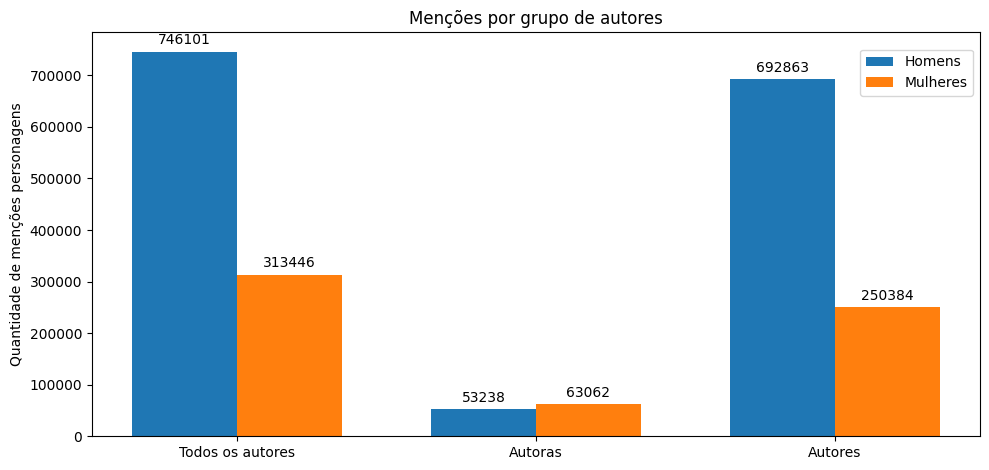

In [ ]:
from importlib import reload
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from os import path


labels = ['Todos os autores', 'Autoras', 'Autores']
men_count = [0, 0, 0]
women_count = [0, 0, 0]

for obj in author_list:
  men_count[0] = men_count[0] + obj.mentions[Gender.MALE]
  women_count[0] = women_count[0] + obj.mentions[Gender.FEMALE]

for obj in female_author_list:
  men_count[1] = men_count[1] + obj.mentions[Gender.MALE]
  women_count[1] = women_count[1] + obj.mentions[Gender.FEMALE]

for obj in male_author_list:
  men_count[2] = men_count[2] + obj.mentions[Gender.MALE]
  women_count[2] = women_count[2] + obj.mentions[Gender.FEMALE]

x = np.arange(len(labels))
width = 0.35 # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_count, width, label='Homens')
rects2 = ax.bar(x + width/2, women_count, width, label='Mulheres')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Quantidade de menções personagens')
ax.set_title('Menções por grupo de autores')
ax.set_xticks(x, labels)
ax.legend([rects1, rects2], ['Homens', 'Mulheres'], bbox_to_anchor=[1, 0.9], loc='right')

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.set_figwidth(10)

fig.tight_layout()

plt.show()

# print(objdump.adjectives[Gender.MALE])
# print(objdump.adjectives[Gender.FEMALE])
# print(objdump.verbs[Gender.MALE])
# print(objdump.verbs[Gender.FEMALE])
# print(objdump.occupations[Gender.MALE])
# print(objdump.occupations[Gender.FEMALE])
# print(objdump.mentions[Gender.MALE])
# print(objdump.mentions[Gender.FEMALE])
# print(objdump.characters[Gender.MALE])
# print(objdump.characters[Gender.FEMALE])
# print(objdump.book.filename)

## Amount of named characters

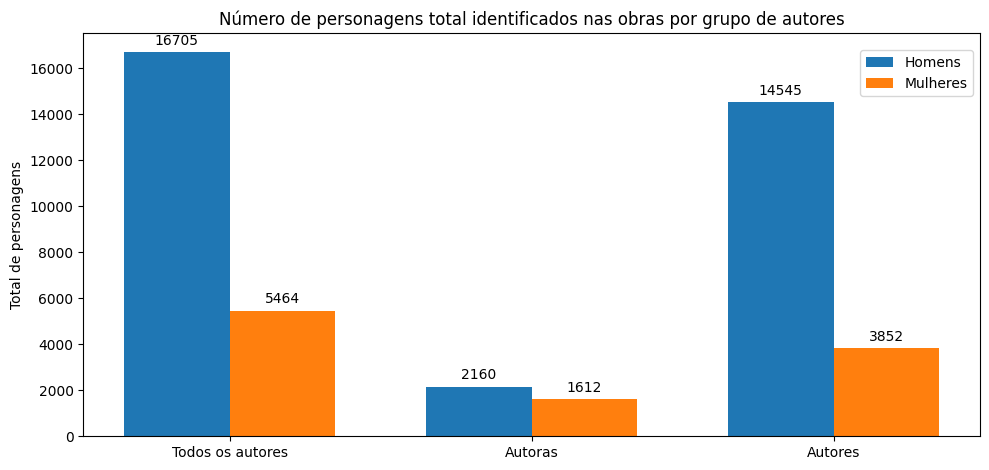

In [ ]:
from importlib import reload
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from os import path


labels = ['Todos os autores', 'Autoras', 'Autores']
men_count = [0, 0, 0]
women_count = [0, 0, 0]

for obj in author_list:
  men_count[0] = men_count[0] + len(obj.characters[Gender.MALE])
  women_count[0] = women_count[0] + len(obj.characters[Gender.FEMALE])

for obj in female_author_list:
  men_count[1] = men_count[1] + len(obj.characters[Gender.MALE])
  women_count[1] = women_count[1] + len(obj.characters[Gender.FEMALE])

for obj in male_author_list:
  men_count[2] = men_count[2] + len(obj.characters[Gender.MALE])
  women_count[2] = women_count[2] + len(obj.characters[Gender.FEMALE])

x = np.arange(len(labels))
width = 0.35 # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_count, width, label='Homens')
rects2 = ax.bar(x + width/2, women_count, width, label='Mulheres')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total de personagens')
ax.set_title('Número de personagens total identificados nas obras por grupo de autores')
ax.set_xticks(x, labels)
ax.legend([rects1, rects2], ['Homens', 'Mulheres'], bbox_to_anchor=[1, 0.9], loc='right')

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.set_figwidth(10)

fig.tight_layout()

plt.show()

## Livros com mais menções a mulheres

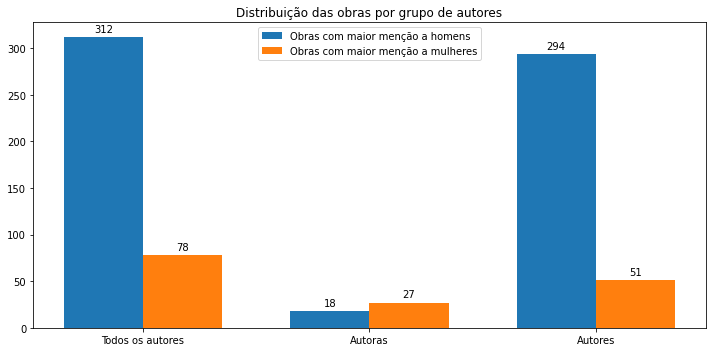

In [ ]:
from importlib import reload
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from os import path


labels = ['Todos os autores', 'Autoras', 'Autores']
more_women_count = [0, 0, 0]
more_men_count = [0, 0, 0]

for obj in author_list:
  if obj.mentions[Gender.MALE] > obj.mentions[Gender.FEMALE]:
    more_men_count[0] = more_men_count[0] + 1
  else:
    more_women_count[0] = more_women_count[0] + 1

for obj in female_author_list:
  if obj.mentions[Gender.MALE] > obj.mentions[Gender.FEMALE]:
    more_men_count[1] = more_men_count[1] + 1
  else:
    more_women_count[1] = more_women_count[1] + 1

for obj in male_author_list:
  if obj.mentions[Gender.MALE] > obj.mentions[Gender.FEMALE]:
    more_men_count[2] = more_men_count[2] + 1
  else:
    more_women_count[2] = more_women_count[2] + 1

x = np.arange(len(labels))
width = 0.35 # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, more_men_count, width, label='Obras com maior menção a homens')
rects2 = ax.bar(x + width/2, more_women_count, width, label='Obras com maior menção a mulheres')

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('')
ax.set_title('Distribuição das obras por grupo de autores')
ax.set_xticks(x, labels)
ax.legend([rects1, rects2], ['Obras com maior menção a homens', 'Obras com maior menção a mulheres'])

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.set_figwidth(10)
fig.set_figheight(5)

fig.tight_layout()

plt.show()

# print(objdump.adjectives[Gender.MALE])
# print(objdump.adjectives[Gender.FEMALE])
# print(objdump.verbs[Gender.MALE])
# print(objdump.verbs[Gender.FEMALE])
# print(objdump.occupations[Gender.MALE])
# print(objdump.occupations[Gender.FEMALE])
# print(objdump.mentions[Gender.MALE])
# print(objdump.mentions[Gender.FEMALE])
# print(objdump.characters[Gender.MALE])
# print(objdump.characters[Gender.FEMALE])
# print(objdump.book.filename)

## Livro com conjunto de personagens mulheres maior do que dos homens

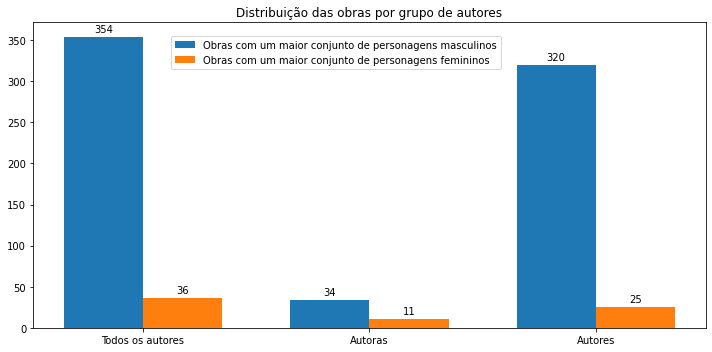

In [ ]:
from importlib import reload
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from os import path


labels = ['Todos os autores', 'Autoras', 'Autores']
more_women_count = [0, 0, 0]
more_men_count = [0, 0, 0]

for obj in author_list:
  if len(obj.characters[Gender.MALE]) > len(obj.characters[Gender.FEMALE]):
    more_men_count[0] = more_men_count[0] + 1
  else:
    more_women_count[0] = more_women_count[0] + 1

for obj in female_author_list:
  if len(obj.characters[Gender.MALE]) > len(obj.characters[Gender.FEMALE]):
    more_men_count[1] = more_men_count[1] + 1
  else:
    more_women_count[1] = more_women_count[1] + 1

for obj in male_author_list:
  if len(obj.characters[Gender.MALE]) > len(obj.characters[Gender.FEMALE]):
    more_men_count[2] = more_men_count[2] + 1
  else:
    more_women_count[2] = more_women_count[2] + 1

x = np.arange(len(labels))
width = 0.35 # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, more_men_count, width, label='Obras com um maior conjunto de personagens masculinos')
rects2 = ax.bar(x + width/2, more_women_count, width, label='Obras com um maior conjunto de personagens femininos')

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('')
ax.set_title('Distribuição das obras por grupo de autores')
ax.set_xticks(x, labels)
ax.legend([rects1, rects2], ['Obras com um maior conjunto de personagens masculinos', 'Obras com um maior conjunto de personagens femininos'], bbox_to_anchor=[0.45, 0.9], loc='center')

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.set_figwidth(10)
fig.set_figheight(5)

fig.tight_layout()

plt.show()

# print(objdump.adjectives[Gender.MALE])
# print(objdump.adjectives[Gender.FEMALE])
# print(objdump.verbs[Gender.MALE])
# print(objdump.verbs[Gender.FEMALE])
# print(objdump.occupations[Gender.MALE])
# print(objdump.occupations[Gender.FEMALE])
# print(objdump.mentions[Gender.MALE])
# print(objdump.mentions[Gender.FEMALE])
# print(objdump.characters[Gender.MALE])
# print(objdump.characters[Gender.FEMALE])
# print(objdump.book.filename)

## Extract adjective information and build data frame

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import pandas as pd
from PIL import Image
from textwrap import wrap
import matplotlib.pyplot as plt

male_adjective_list = [[], [], []]
female_adjective_list = [[], [], []]

for obj in author_list:
  male_adjective_list[0] = male_adjective_list[0] + obj.adjectives[Gender.MALE]
  female_adjective_list[0] = female_adjective_list[0] + obj.adjectives[Gender.FEMALE]

for obj in female_author_list:
  male_adjective_list[1] = male_adjective_list[1] + obj.adjectives[Gender.MALE]
  female_adjective_list[1] = female_adjective_list[1] + obj.adjectives[Gender.FEMALE]

for obj in male_author_list:
  male_adjective_list[2] = male_adjective_list[2] + obj.adjectives[Gender.MALE]
  female_adjective_list[2] = female_adjective_list[2] + obj.adjectives[Gender.FEMALE]


print('Todos os autores')
male_data = pd.DataFrame({'Male': male_adjective_list[0]}, columns=['Male'])
df = pd.crosstab(index=male_data['Male'], columns='count')
most_adjectives_female = 
print(df.sort_values(by=['count'], ascending=False).head(20))
print()

female_data = pd.DataFrame({'Female': female_adjective_list[0]}, columns=['Female'])
female_df = pd.crosstab(index=female_data['Female'], columns='count')
print(female_df.sort_values(by=['count'], ascending=False).head(20))
print()

print('Autoras')
male_data = pd.DataFrame({'Male': male_adjective_list[1]}, columns=['Male'])
df = pd.crosstab(index=male_data['Male'], columns='count')
print(df.sort_values(by=['count'], ascending=False).head(20))
print()

female_data = pd.DataFrame({'Female': female_adjective_list[1]}, columns=['Female'])
female_df = pd.crosstab(index=female_data['Female'], columns='count')
print(female_df.sort_values(by=['count'], ascending=False).head(20))
print()

print('Autores')
male_data = pd.DataFrame({'Male': male_adjective_list[2]}, columns=['Male'])
df = pd.crosstab(index=male_data['Male'], columns='count')
print(df.sort_values(by=['count'], ascending=False).head(20))
print()

female_data = pd.DataFrame({'Female': female_adjective_list[2]}, columns=['Female'])
female_df = pd.crosstab(index=female_data['Female'], columns='count')
print(female_df.sort_values(by=['count'], ascending=False).head(20))
print()

# # TODO OS AUTORES

# wordcloud = WordCloud(width = 800, height = 800,
#                 background_color = 'white',
#                 collocations = False,
#                 min_font_size = 10).generate(' '.join(male_adjective_list[0]))
 
# # plot the WordCloud image                      
# plt.figure(figsize = (6, 6), facecolor = None)
# plt.title('\n'.join(wrap('Adjetivos associados a personagens masculinos para todos os autores', 40)), fontsize = 20)
# plt.imshow(wordcloud)
# plt.axis('off')
# plt.tight_layout(pad = 0)
 
# plt.show()

# wordcloud = WordCloud(width = 800, height = 800,
#                       background_color = 'white',
#                       collocations = False,
#                       min_font_size = 10).generate(' '.join(female_adjective_list[0]))

# plt.figure(figsize = (6, 6), facecolor = None)
# plt.title('\n'.join(wrap('Adjetivos associados a personagens femininos para todos os autores', 40)), fontsize = 20)
# plt.imshow(wordcloud)
# plt.axis('off')
# plt.tight_layout(pad = 0)

# plt.show()

# # AUTORAS

# wordcloud = WordCloud(width = 800, height = 800,
#                 background_color = 'white',
#                 collocations = False,
#                 min_font_size = 10).generate(' '.join(male_adjective_list[1]))
 
# # plot the WordCloud image                      
# plt.figure(figsize = (6, 6), facecolor = None)
# plt.title('\n'.join(wrap('Adjetivos associados a personagens masculinos nos livros de autoras', 40)), fontsize = 20)
# plt.imshow(wordcloud)
# plt.axis('off')
# plt.tight_layout(pad = 0)
 
# plt.show()

# wordcloud = WordCloud(width = 800, height = 800,
#                       background_color = 'white',
#                       collocations = False,
#                       min_font_size = 10).generate(' '.join(female_adjective_list[1]))

# plt.figure(figsize = (6, 6), facecolor = None)
# plt.title('\n'.join(wrap('Adjetivos associados a personagens femininos para nos livros de autoras', 40)), fontsize = 20)
# plt.imshow(wordcloud)
# plt.axis('off')
# plt.tight_layout(pad = 0)
 
# plt.show()

# # AUTORES

# wordcloud = WordCloud(width = 800, height = 800,
#                 background_color = 'white',
#                 collocations = False,
#                 min_font_size = 10).generate(' '.join(male_adjective_list[2]))
 
# # plot the WordCloud image                      
# plt.figure(figsize = (6, 6), facecolor = None)
# plt.title('\n'.join(wrap('Adjetivos associados a personagens masculinos nos livros de autores', 40)), fontsize = 20)
# plt.imshow(wordcloud)
# plt.axis('off')
# plt.tight_layout(pad = 0)
 
# plt.show()

# wordcloud = WordCloud(width = 800, height = 800,
#                       background_color = 'white',
#                       collocations = False,
#                       min_font_size = 10).generate(' '.join(female_adjective_list[2]))

# plt.figure(figsize = (6, 6), facecolor = None)
# plt.title('\n'.join(wrap('Adjetivos associados a personagens femininos para nos livros de autores', 40)), fontsize = 20)
# plt.imshow(wordcloud)
# plt.axis('off')
# plt.tight_layout(pad = 0)
 
# plt.show()

Todos os autores
col_0   count
Male         
little   6621
old      4273
good     4216
great    3695
own      3290
young    3279
other    3178
long     3022
last     2884
first    2780
much     2703
few      2582
small    2356
white    2356
black    2052
large    1932
same     1906
big      1892
dark     1825
full     1794

col_0      count
Female          
little      4195
old         2331
full        2061
white       1807
own         1508
great       1393
good        1374
young       1322
black       1110
beautiful   1047
sweet       1015
much        1013
last         957
first        956
brown        952
other        930
dark         882
long         864
tall         793
new          653

Autoras
col_0     count
Male           
little      751
old         548
good        383
young       275
long        256
much        248
own         246
first       235
big         216
red         214
handsome    213
great       195
other       191
such        188
last        184
black       169
blu

## Extract verbs

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import pandas as pd
from PIL import Image
from textwrap import wrap
import matplotlib.pyplot as plt

male_verb_list = [[], [], []]
female_verb_list = [[], [], []]

for obj in author_list:
  male_verb_list[0] = male_verb_list[0] + obj.verbs[Gender.MALE]
  female_verb_list[0] = female_verb_list[0] + obj.verbs[Gender.FEMALE]

for obj in female_author_list:
  male_verb_list[1] = male_verb_list[1] + obj.verbs[Gender.MALE]
  female_verb_list[1] = female_verb_list[1] + obj.verbs[Gender.FEMALE]

for obj in male_author_list:
  male_verb_list[2] = male_verb_list[2] + obj.verbs[Gender.MALE]
  female_verb_list[2] = female_verb_list[2] + obj.verbs[Gender.FEMALE]


print('Todos os autores')
male_data = pd.DataFrame({'Male': male_verb_list[0]}, columns=['Male'])
df = pd.crosstab(index=male_data['Male'], columns='count')
print(df.sort_values(by=['count'], ascending=False).head(20))
print()

female_data = pd.DataFrame({'Female': female_verb_list[0]}, columns=['Female'])
female_df = pd.crosstab(index=female_data['Female'], columns='count')
print(female_df.sort_values(by=['count'], ascending=False).head(20))
print()

print('Autoras')
male_data = pd.DataFrame({'Male': male_verb_list[1]}, columns=['Male'])
df = pd.crosstab(index=male_data['Male'], columns='count')
print(df.sort_values(by=['count'], ascending=False).head(20))
print()

female_data = pd.DataFrame({'Female': female_verb_list[1]}, columns=['Female'])
female_df = pd.crosstab(index=female_data['Female'], columns='count')
print(female_df.sort_values(by=['count'], ascending=False).head(20))
print()

print('Autores')
male_data = pd.DataFrame({'Male': male_verb_list[2]}, columns=['Male'])
df = pd.crosstab(index=male_data['Male'], columns='count')
print(df.sort_values(by=['count'], ascending=False).head(20))
print()

female_data = pd.DataFrame({'Female': female_verb_list[2]}, columns=['Female'])
female_df = pd.crosstab(index=female_data['Female'], columns='count')
print(female_df.sort_values(by=['count'], ascending=False).head(20))
print()

occupations = []
for obj in author_list:
  occupations = occupations + obj.occupations[Gender.MALE]
  occupations = occupations + obj.occupations[Gender.FEMALE]

Todos os autores
col_0    count
Male          
had      18139
man      12718
work      4497
have      3226
go        3066
was       2921
place     2368
look      2247
think     2209
looking   2182
came      2159
known     1884
come      1829
went      1712
do        1510
get       1451
were      1444
see       1335
looked    1308
chair     1283

col_0    count
Female        
had       6887
man       1835
have      1311
look      1304
go         946
looking    914
lived      882
was        873
work       862
went       835
dressed    776
place      740
come       717
writing    679
coming     622
came       573
falling    551
speak      531
said       519
sat        516

Autoras
col_0    count
Male          
had       1100
man       1064
looking    300
place      275
were       264
book       241
was        234
came       217
going      212
work       206
found      187
have       165
went       164
sat        164
look       158
go         152
has        148
do         147
got        14

## Wordcloud Verbos

Autoras


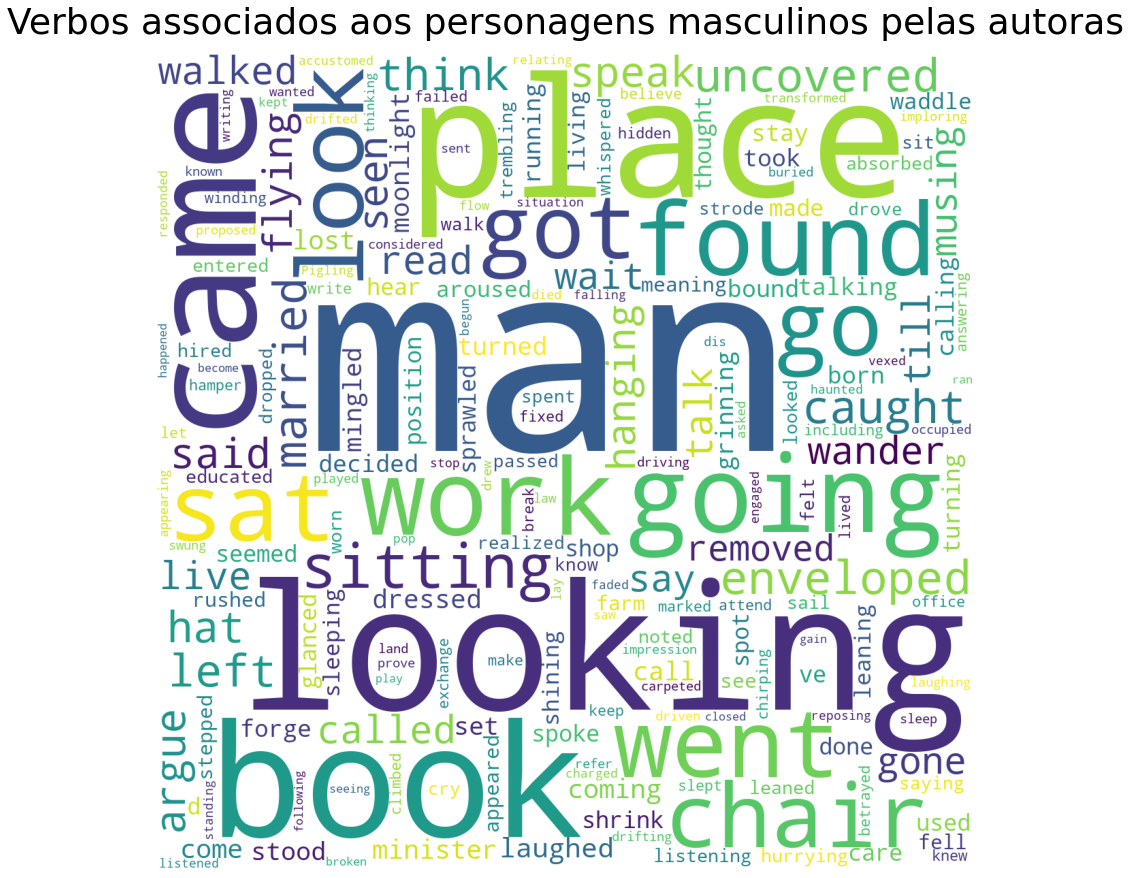

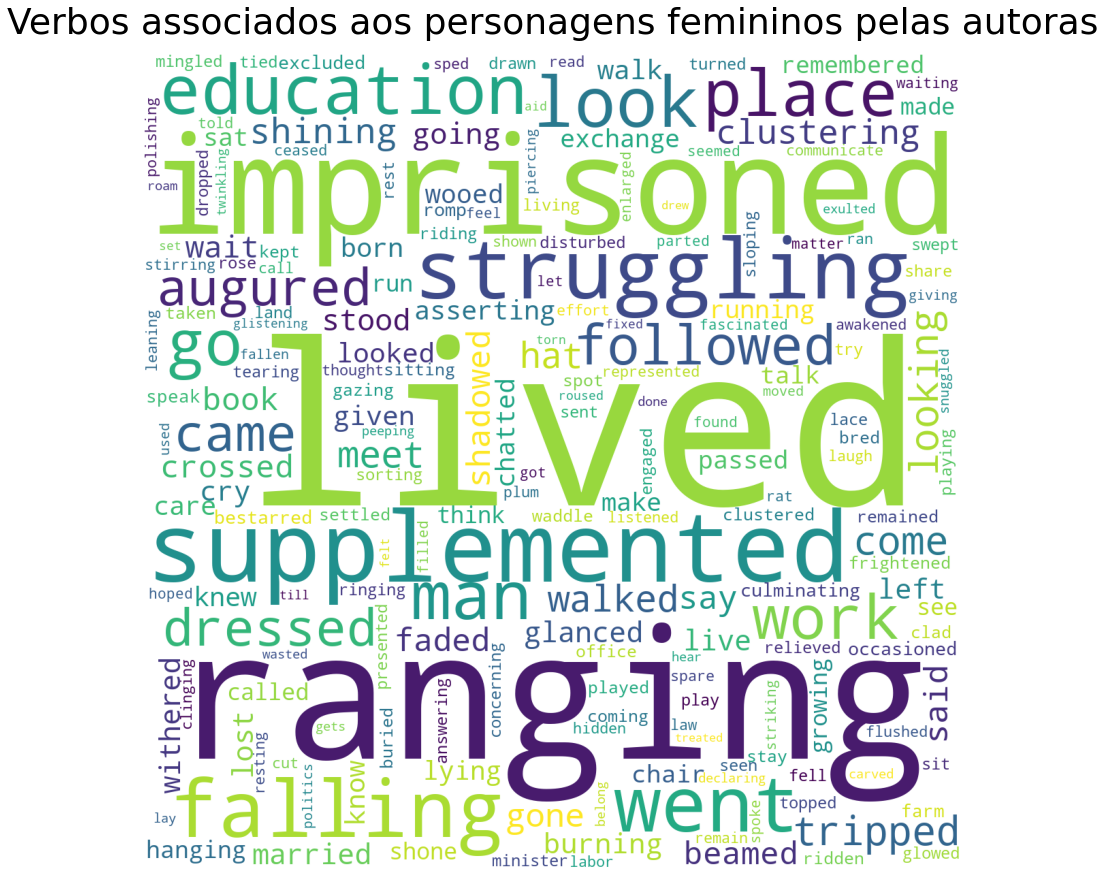


Autores


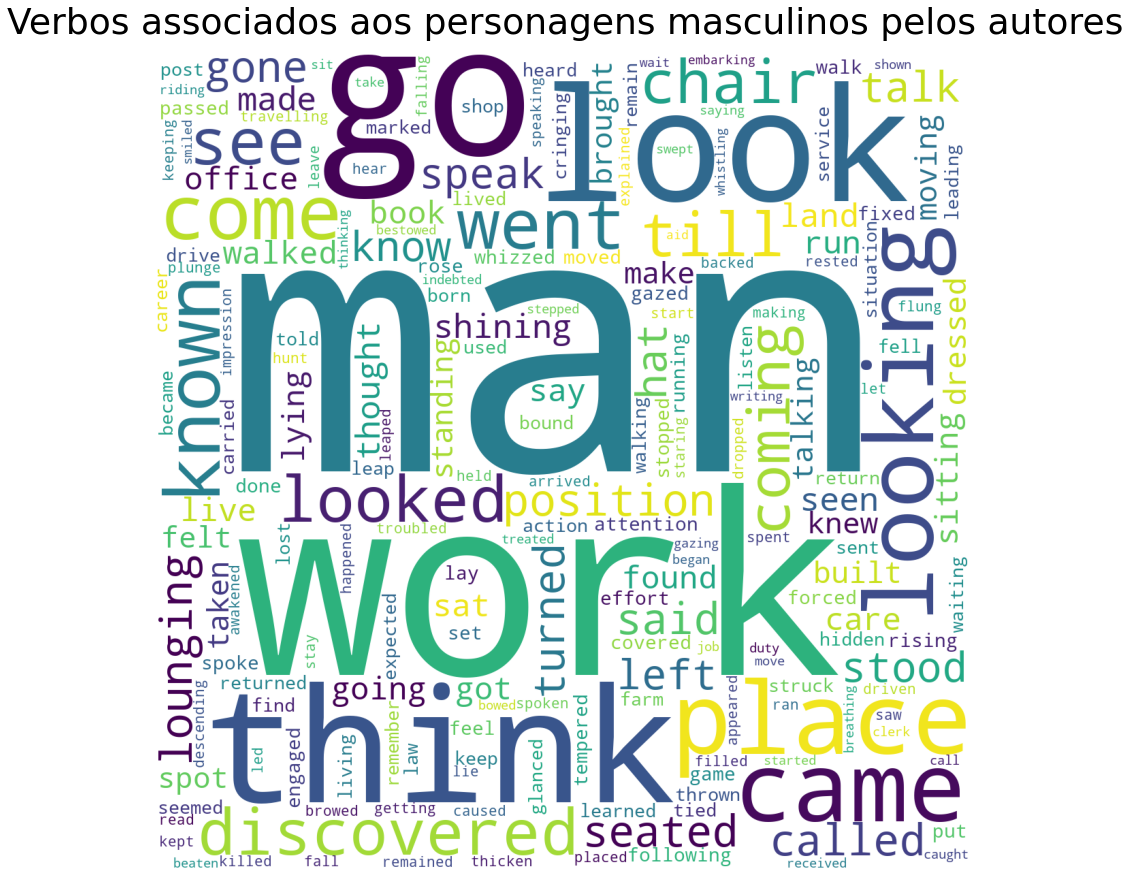

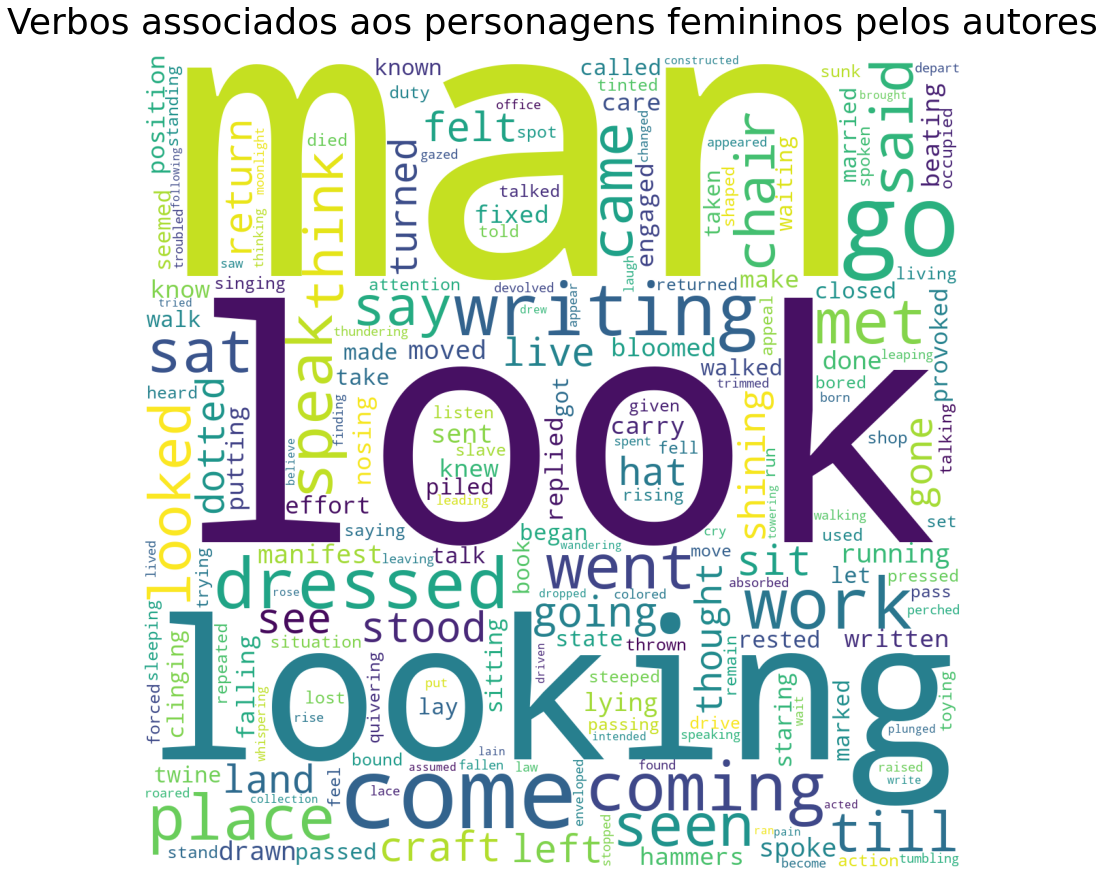

In [ ]:
from wordcloud import WordCloud, STOPWORDS
from os import path
import numpy as np
import pandas as pd
from PIL import Image
from textwrap import wrap
import matplotlib.pyplot as plt

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# boy_female_mask = np.array(Image.open(path.join(d, 'boy-female-authors.png')))
# girl_female_mask = np.array(Image.open(path.join(d, 'girl-female-authors.png')))

boy_male_mask = np.array(Image.open(path.join(d, 'boy-male-authors.png')))
girl_male_mask = np.array(Image.open(path.join(d, 'girl-male-authors.jpg')))

male_verb_list = [[], []]
female_verb_list = [[], []]

for obj in female_author_list:
  male_verb_list[0] = male_verb_list[0] + obj.verbs[Gender.MALE]
  female_verb_list[0] = female_verb_list[0] + obj.verbs[Gender.FEMALE]

for obj in male_author_list:
  male_verb_list[1] = male_verb_list[1] + obj.verbs[Gender.MALE]
  female_verb_list[1] = female_verb_list[1] + obj.verbs[Gender.FEMALE]


print('Autoras')
wordcloud = WordCloud(width = 1200, height = 1200,
                background_color = 'white',
                collocations = False,
                contour_width=3,
                contour_color='steelblue',
                min_font_size = 10).generate(' '.join(male_verb_list[0]))

wordcloud.to_file(path.join(d, 'masculino-autoras.png'))

 
# plot the WordCloud image
plt.figure(figsize = (12, 12), facecolor = None)
plt.title('Verbos associados aos personagens masculinos pelas autoras', fontsize = 36, pad = 20)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)

plt.show()

wordcloud = WordCloud(width = 1200, height = 1200,
                background_color = 'white',
                collocations = False,
                contour_width=3,
                contour_color='steelblue',
                min_font_size = 10).generate(' '.join(female_verb_list[0]))

wordcloud.to_file(path.join(d, 'femininos-autoras.png'))
 
# plot the WordCloud image
plt.figure(figsize = (12, 12), facecolor = None)
plt.title('Verbos associados aos personagens femininos pelas autoras', fontsize = 36, pad = 20)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
 
plt.show()

print()

print('Autores')
wordcloud = WordCloud(width = 1200, height = 1200,
                background_color = 'white',
                collocations = False,
                contour_width=3,
                contour_color='steelblue',
                min_font_size = 10).generate(' '.join(male_verb_list[1]))

wordcloud.to_file(path.join(d, "masculino-autores.png"))
 
# plot the WordCloud image
plt.figure(figsize = (12, 12), facecolor = None)    
plt.title('Verbos associados aos personagens masculinos pelos autores', fontsize = 36, pad = 20)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
 
plt.show()

wordcloud = WordCloud(width = 1200, height = 1200,
                background_color = 'white',
                collocations = False,
                contour_width=3,
                contour_color='steelblue',
                min_font_size = 10).generate(' '.join(female_verb_list[1]))

wordcloud.to_file(path.join(d, "femininos-autores.png"))
 
# plot the WordCloud image
plt.figure(figsize = (12, 12), facecolor = None)    
plt.title('Verbos associados aos personagens femininos pelos autores', fontsize = 36, pad = 20)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
 
plt.show()

# Teste com o artigo Madaan

In [ ]:
import os
import stanza
import re
import nltk
import time
import multiprocessing
import pickle
import sys
from nltk.corpus import brown
from nltk.corpus import wordnet as wn
from stanza.server import CoreNLPClient, AnnotationException, PermanentlyFailedException


def pipeline(port, retries = 0):
  with open('madaan-article.txt', 'r') as file:
    try:
      data = file.read()
      print('Starting pipeline for book madaan-article.txt')
      ann = None
      with CoreNLPClient(
          annotators = ['tokenize', 'ssplit', 'pos', 'lemma', 'ner', 'depparse', 'natlog', 'openie', 'coref'],
          be_quiet = False,
          timeout = 150000000000,
          memory = '10G',
          endpoint = f'http://localhost:{port}',
          max_char_length = 20000000000000000) as client:
            ann = client.annotate(data)

            sentences = ann.sentence
            maleRegex = re.compile(r'\b(he|his|him|himself)\b', re.IGNORECASE)
            femaleRegex = re.compile(r'\b(her|she|hers|herself)\b', re.IGNORECASE)
            maleMentions = 0
            femaleMentions = 0
            male_characters = set()
            female_characters = set()

            """MENCOES"""

            for sentence in sentences:
              for triple in sentence.openieTriple:
                if len(triple.tree.node) > 0 and (any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('PRP') for subject in triple.subjectTokens)):
                  # print(f'Subject tokens: {list(map(lambda x: sentences[x.sentenceIndex].token[x.tokenIndex].value, triple.subjectTokens))} related to Object tokens: {list(map(lambda x: sentences[x.sentenceIndex].token[x.tokenIndex].value, triple.objectTokens))}')
                  for su in triple.subjectTokens:
                    if maleRegex.search(sentences[su.sentenceIndex].token[su.tokenIndex].value):
                      maleMentions += 1
                      break
                    elif femaleRegex.search(sentences[su.sentenceIndex].token[su.tokenIndex].value):
                      femaleMentions += 1
                      break

            chains = ann.corefChain
            chain_dict = dict()

            for index, chain in enumerate(chains):
              chain_dict[index]={}
              chain_dict[index]['ref']=''
              chain_dict[index]['mentions']=[{'mentionID':mention.mentionID,
                                                      'mentionType':mention.mentionType,
                                                      'number':mention.number,
                                                      'gender':mention.gender,
                                                      'animacy':mention.animacy,
                                                      'beginIndex':mention.beginIndex,
                                                      'endIndex':mention.endIndex,
                                                      'headIndex':mention.headIndex,
                                                      'sentenceIndex':mention.sentenceIndex,
                                                      'position':mention.position,
                                                      'ref':'',
                                                      } for mention in chain.mention ]
            for k, v in chain_dict.items():
              mentions = v['mentions']
              for mention in mentions:
                words_list = ann.sentence[mention['sentenceIndex']].token[mention['beginIndex']:mention['endIndex']]
                mention['ref'] = ' '.join(t.word for t in words_list)
                if mention['mentionType'] == 'PROPER' and any(word.pos == 'NNP' for word in words_list):
                  if mention['gender'] == 'MALE':
                    maleMentions += 1
                    for word in words_list:
                      if word.pos == 'NNP':
                        male_characters.add(word.value)
                  elif mention['gender'] == 'FEMALE':
                    femaleMentions += 1
                    for word in words_list:
                      if word.pos == 'NNP':
                        female_characters.add(word.value)
            print(f'The number of males mentioned in the text is {maleMentions}')
            print(f'The number of females mentioned in the text is {femaleMentions}')
            print(f'Male character set {male_characters}')
            print(f'Female character set {female_characters}')

            """ADJECTIVES"""

            male_adjective_list = []
            female_adjective_list = []
            male_verification = lambda x: maleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
            female_verification = lambda x: femaleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
            # Get adjectives for pronoun or possessive pronoun
            for sentence in sentences:
              for triple in sentence.openieTriple:
                if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('PRP') for subject in triple.subjectTokens):
                  male_verification_list = list(filter(male_verification, triple.subjectTokens))
                  female_verification_list = list(filter(female_verification, triple.subjectTokens))
                  if len(male_verification_list) > 0:
                    for obj in triple.objectTokens:
                      if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('JJ'):
                        male_adjective_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                    continue
                  elif len(female_verification_list) > 0:
                    for obj in triple.objectTokens:
                      if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('JJ'):
                        female_adjective_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                    continue
            # Get adjectives for proper noun
            for sentence in sentences:
              for triple in sentence.openieTriple:
                if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') for subject in triple.subjectTokens):
                  # print(triple.subjectTokens[0].sentenceIndex, triple.subjectTokens[-1].sentenceIndex)
                  tokens = [sentences[x.sentenceIndex].token[x.tokenIndex].value for x in triple.subjectTokens]
                  subject = ' '.join(tokens)
                  if subject in male_characters:
                    for obj in triple.objectTokens:
                      if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('JJ'):
                        male_adjective_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                    continue
                  elif subject in female_characters:
                    for obj in triple.objectTokens:
                      if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('JJ'):
                        female_adjective_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                    continue
            
            """VERBS"""
            male_verb_list = []
            female_verb_list = []
            male_verification = lambda x: maleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
            female_verification = lambda x: femaleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
            # Get adjectives for pronoun or possessive pronoun
            for sentence in sentences:
              for triple in sentence.openieTriple:
                if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('PRP') for subject in triple.subjectTokens):
                  male_verification_list = list(filter(male_verification, triple.subjectTokens))
                  female_verification_list = list(filter(female_verification, triple.subjectTokens))
                  if len(male_verification_list) > 0:
                    for obj in triple.objectTokens:
                      if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('VB'):
                        male_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                    continue
                  elif len(female_verification_list) > 0:
                    for obj in triple.objectTokens:
                      if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('VB'):
                        female_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                    continue
            # Get adjectives for proper noun
            for sentence in sentences:
              for triple in sentence.openieTriple:
                if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') for subject in triple.subjectTokens):
                  # print(triple.subjectTokens[0].sentenceIndex, triple.subjectTokens[-1].sentenceIndex)
                  tokens = [sentences[x.sentenceIndex].token[x.tokenIndex].value for x in triple.subjectTokens]
                  subject = ' '.join(tokens)
                  if subject in male_characters:
                    for obj in triple.objectTokens:
                      if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('VB'):
                        male_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                    continue
                  elif subject in female_characters:
                    for obj in triple.objectTokens:
                      if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('VB'):
                        female_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                    continue
            
            """OCCUPATIONS"""
            male_occupation_list = []
            female_occupation_list = []
            male_verification = lambda x: maleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
            female_verification = lambda x: femaleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
            # Get occupation for pronoun or possessive pronoun
            for sentence in sentences:
              for triple in sentence.openieTriple:
                # (sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') and (sentences[subject.sentenceIndex].token[subject.tokenIndex].value in male_characters or sentences[subject.sentenceIndex].token[subject.tokenIndex].value in female_characters
                if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('PRP') for subject in triple.subjectTokens):
                  male_verification_list = list(filter(male_verification, triple.subjectTokens))
                  female_verification_list = list(filter(female_verification, triple.subjectTokens))
                  if len(male_verification_list) > 0:
                    for obj in triple.objectTokens:
                      if sentences[obj.sentenceIndex].token[obj.tokenIndex].value in complete_list_professions:
                        male_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                    continue
                  elif len(female_verification_list) > 0:
                    for obj in triple.objectTokens:
                      if sentences[obj.sentenceIndex].token[obj.tokenIndex].value in complete_list_professions:
                        female_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                    continue
            # Get professions for proper noun
            for sentence in sentences:
              for triple in sentence.openieTriple:
                if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') for subject in triple.subjectTokens):
                  # print(triple.subjectTokens[0].sentenceIndex, triple.subjectTokens[-1].sentenceIndex)
                  tokens = [sentences[x.sentenceIndex].token[x.tokenIndex].value for x in triple.subjectTokens]
                  subject = ' '.join(tokens)
                  if subject in male_characters:
                    for obj in triple.objectTokens:
                      if sentences[obj.sentenceIndex].token[obj.tokenIndex].value in complete_list_professions:
                        male_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                    continue
                  elif subject in female_characters:
                    for obj in triple.objectTokens:
                      if sentences[obj.sentenceIndex].token[obj.tokenIndex].value in complete_list_professions:
                        female_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                    continue

            print(male_occupation_list)
            print(female_occupation_list)

            """ARMAZENA OS DADOS"""
            RESULTS_HOME = '.'

            data = AnalysisResult(book)
            data.adjectives[Gender.MALE] = male_adjective_list
            data.adjectives[Gender.FEMALE] = female_adjective_list
            data.verbs[Gender.MALE] = male_verb_list
            data.verbs[Gender.FEMALE] = female_verb_list
            data.occupations[Gender.MALE] = male_occupation_list
            data.occupations[Gender.FEMALE] = female_occupation_list
            data.mentions[Gender.MALE] = maleMentions
            data.mentions[Gender.FEMALE] = femaleMentions
            data.characters[Gender.MALE] = male_characters
            data.characters[Gender.FEMALE] = female_characters

            print(data.adjectives[Gender.MALE])
            print(data.adjectives[Gender.FEMALE])
            print(re.sub('txt', 'pickle', 'madaan-article.txt'))

            with open(f"{RESULTS_HOME}/{re.sub('txt', 'pickle', 'madaan-article.txt')}", 'wb') as f:
              pickle.dump(data, f)

            objdump = None
            
            with open(f"{RESULTS_HOME}/{re.sub('txt', 'pickle', 'madaan-article.txt')}", 'rb') as f:
              # Stores the now deserialized information into objdump
              objdump = pickle.load(f)

            print(objdump.adjectives[Gender.MALE])
            print(objdump.adjectives[Gender.FEMALE])
            print(objdump.verbs[Gender.MALE])
            print(objdump.verbs[Gender.FEMALE])
            print(objdump.occupations[Gender.MALE])
            print(objdump.occupations[Gender.FEMALE])
            print(objdump.mentions[Gender.MALE])
            print(objdump.mentions[Gender.FEMALE])
            print(objdump.characters[Gender.MALE])
            print(objdump.characters[Gender.FEMALE])
            print(objdump)

            print('Finished pipeline for book madaan-article.txt')
    except OSError:
      calculated_port = port + 1 % 65535
      calculated_port =  calculated_port + 49152 if calculated_port < 49152 else calculated_port
      pipeline(book, calculated_port, retries + 1)
      print(f'Problem starting the server, port {calculated_port} already in use.')
    except PermanentlyFailedException:
      if retries > 10:
        print('More than 10 tries to start the server, aborting...')
        sys.exit('Aborting after more than 10 successive attempts to start the server')
      calculated_port = port + 1 % 65535
      calculated_port =  calculated_port + 49152 if calculated_port < 49152 else calculated_port
      print('There was a problem starting the server')
      print('Trying to restart on another port')
      pipeline(book, calculated_port)
    except AnnotationException:
      print(f'Error while trying to create annotations for {book.filename}')


if __name__ == '__main__':
  nltk.download('wordnet')
  nltk.download('wordnet31')
  nltk.download('omw-1.4')
  nltk.download('brown')

  profession_expression = re.compile(r'Profession|position|occupation|line of work|employment|occupancy|work|role|labor|industry|job', re.IGNORECASE)

  def get_hyponyms(synset, hyponyms = set()):
    for hyponym in synset.hyponyms():
      hyponyms |= set(synset.closure(lambda s: s.hyponyms()))
      hyponyms |= get_hyponyms(hyponym, hyponyms)
    return hyponyms | set(synset.closure(lambda s: s.hyponyms()))

  def filter_occupations(set_data):
    return set(filter(lambda x: profession_expression.search(x.definition()), set_data))

  work = wn.synsets('work')
  job = wn.synsets('job')
  occupation = wn.synset('occupation.n.01')
  profession1 = wn.synset('profession.n.01')
  profession2 = wn.synset('profession.n.02')

  print(work)
  print(job)

  complete_list_professions = get_hyponyms(occupation).union(get_hyponyms(profession1), get_hyponyms(profession2))

  for x in work:
    complete_list_professions = complete_list_professions.union(get_hyponyms(x))

  for x in job:
    complete_list_professions = complete_list_professions.union(get_hyponyms(x))

  print(complete_list_professions)

  complete_list_professions = filter_occupations(complete_list_professions)

  complete_list_professions = list(map(lambda x: x.lemma_names(), complete_list_professions))

  complete_list_professions = [item for sublist in complete_list_professions for item in sublist]
  complete_list_professions = list(map(lambda x: x.replace('_', ' '), complete_list_professions))

  print(complete_list_professions)
  print(len(complete_list_professions))

  # Download the Stanford CoreNLP package with Stanza's installation command
  # This'll take several minutes, depending on the network speed
  corenlp_dir = './corenlp'
  stanza.install_corenlp(dir=corenlp_dir)

  # Set the CORENLP_HOME environment variable to point to the installation location
  os.environ['CORENLP_HOME'] = corenlp_dir
  # Skipped #4 => Anthony Trollope's Ayala's Angel 
  # Skipped #5 => Anthony Trollope's Barchester Towers
  # Skipped #6 => Anthony Trollope's Can You Forgive Her?
  # Skipped #7 => Anthony Trollope's Castle Richmond
  # Skipped #9 => Anthony Trollope's Doctor Thorne
  # Skipped #11 => Anthony Trollope's Framley Parsonage
  # Skipped #12 => He Knew He Was Right by Anthony Trollope
  # Skipped #13 => Is He Popenjoy? by Anthony Trollope
  # Skipped #33 => A First Family of Tasajara by Bret Harte
  # Skipped #36 => Cressy by Bret Harte
  # Skipped #39 => From Sand Hill to Pine by Bret Harte
  # Skipped #42 => A Tale of Two Cities by Charles Dickens
  # Skipped #44 => David Copperfield by Charles Dickens
  # Skipped #47 => Great Expectations by Charles Dickens
  # Skipped #48 => Hard Times by Charles Dickens
  # Skipped #49 => Jane Eyre by Charlotte Bronte
  # Skipped #50 => Villette by Charlotte Bronte
  # Skipped #51 => Modern Broods by Charlotte Mary Yonge
  # Skipped #53 => The Two Guardians by Charlotte Mary Yonge
  # Skipped The King of Pirates by Daniel Defoe
  # Skipped Richard of Jamestown by James Otis
  port = 49152
  process = multiprocessing.Process(target=pipeline, name="Pipeline", args=(port,))
  process.start()
  process.join(1800)
  # port = port + 1
  if process.is_alive():
    print('madaan-article.txt')
    print(f'Processing of madaan-article took longer than 30 minutes, aborting...')
    
    process.terminate()
    process.join()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet31 to /root/nltk_data...
[nltk_data]   Package wordnet31 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


[Synset('work.n.01'), Synset('work.n.02'), Synset('employment.n.02'), Synset('study.n.02'), Synset('work.n.05'), Synset('workplace.n.01'), Synset('oeuvre.n.01'), Synset('work.v.01'), Synset('work.v.02'), Synset('work.v.03'), Synset('function.v.01'), Synset('work.v.05'), Synset('exercise.v.03'), Synset('make.v.36'), Synset('work.v.08'), Synset('work.v.09'), Synset('work.v.10'), Synset('bring.v.03'), Synset('work.v.12'), Synset('cultivate.v.02'), Synset('work.v.14'), Synset('influence.v.01'), Synset('work.v.16'), Synset('work.v.17'), Synset('work.v.18'), Synset('work.v.19'), Synset('shape.v.02'), Synset('work.v.21'), Synset('knead.v.01'), Synset('exploit.v.01'), Synset('solve.v.01'), Synset('ferment.v.03'), Synset('sour.v.01'), Synset('work.v.27')]
[Synset('occupation.n.01'), Synset('job.n.02'), Synset('job.n.03'), Synset('job.n.04'), Synset('job.n.05'), Synset('job.n.06'), Synset('job.n.07'), Synset('problem.n.01'), Synset('job.n.09'), Synset('job.n.10'), Synset('job.n.11'), Synset('job

{Synset('sinecure.n.02'), Synset('double_leg_circle.n.01'), Synset('naprapathy.n.01'), Synset('enema.n.01'), Synset('president_of_the_united_states.n.02'), Synset('cardiopulmonary_exercise.n.01'), Synset('farm.v.01'), Synset('sex_manual.n.01'), Synset('mcguffey_eclectic_readers.n.01'), Synset('portfolio.n.04'), Synset('cabinet_minister.n.02'), Synset('wardership.n.01'), Synset('shipyard.n.01'), Synset('friction.n.03'), Synset('anointing.n.01'), Synset('pastorship.n.01'), Synset('headship.n.01'), Synset('news_magazine.n.01'), Synset('whip_through.v.01'), Synset('fool's_errand.n.01'), Synset('behavior_therapy.n.01'), Synset('roughcast.v.01'), Synset('consumer_research.n.01'), Synset('likening.n.01'), Synset('papermaking.n.01'), Synset('defibrillation.n.01'), Synset('headmastership.n.01'), Synset('orthodontic_treatment.n.01'), Synset('long_fly.n.01'), Synset('engagement.n.05'), Synset('shingling.n.02'), Synset('lost_cause.n.01'), Synset('community_of_scholars.n.01'), Synset('shop_floor.n.

INFO:stanza:Writing properties to tmp file: corenlp_server-3c2c0dbec1d94f3d.props
INFO:stanza:Starting server with command: java -Xmx10G -cp ./corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 49152 -timeout 150000000000 -threads 5 -maxCharLength 20000000000000000 -quiet False -serverProperties corenlp_server-3c2c0dbec1d94f3d.props -annotators tokenize,ssplit,pos,lemma,ner,depparse,natlog,openie,coref -preload -outputFormat serialized


The number of males mentioned in the text is 9
The number of females mentioned in the text is 9
Male character set {'John', 'Gooden', 'Millar'}
Female character set {'Marneffe', 'Female', 'De'}
[]
[]
['same', 'same', 'same', 'same']
['pink']
madaan-article.pickle
['same', 'same', 'same', 'same']
['pink']
[]
['presented']
[]
[]
9
9
{'John', 'Gooden', 'Millar'}
{'Marneffe', 'Female', 'De'}
Finished pipeline for book madaan-article.txt


# Assign gender to each result

In [ ]:
# import os
# import pickle


# female_authors_for_analysis = { 'Agatha Christie', 'Beatrix Potter', 'Charlotte Bronte',
#                                'Charlotte Mary Yonge', 'George Eliot', 'Jane Austen',
#                                'Louisa May Alcott', 'Lucy Maud Montgomery',
#                                'Mary Shelley', 'Virginia Woolf' }
# """
# In total they collectively have 382 novels.
# 12 novels will be selected from Anthony Trollope and 8 from the rest
# making it 84 in total, the same number as the total number of fiction books
# written by female writers in the corpus.
# Anthony Trollope, Bret Harte, Charles Dickens, Edward Stratemeyer,
# Harold Bindloss, Henry James, Jack London, Nathaniel Hawthorne,
# Wilkie Collins, William Dean Howells
# """
# male_authors_chosen_for_analysis = { 'Aldous Huxley', 'Ambrose Bierce', 'Andrew Lang', 'Anthony Trollope',
#                                     'Benjamin Disraeli', 'Bram Stoker', 'Bret Harte', 'Charles Dickens', 'Charles Kingsley',
#                                     'Daniel Defoe', 'Edgar Allan Poe', 'Edgar Rice Burroughs', 'Edward Phillips Oppenheim',
#                                     'Edward Stratemeyer', 'Frank Richard Stockton', 'George Alfred Henty', 'George Bernard Shaw',
#                                     'Grant Allen', 'Hamlin Garland', 'Harold Bindloss', 'Henry James', 'Henry Rider Haggard',
#                                     'Herbert George Wells', 'Herman Melville', 'Howard Pyle', 'Isaac Asimov', 'Jack London',
#                                     'Jacob Abbott', 'James Fenimore Cooper', 'James Joyce', 'James Matthew Barrie', 'James Otis',
#                                     'John Bunyan', 'John Galsworthy', 'John Keats', 'Joseph Conrad', 'Lewis Carroll', 'Lyman Frank Baum',
#                                     'Mark Twain', 'Nathaniel Hawthorne', 'O Henry', 'Oscar Wilde', 'Philip Kindred Dick', 'R M Ballantyne',
#                                     'Rafael Sabatini', 'Robert Louis Stevenson', 'Rudyard Kipling', 'Sinclair Lewis', 'Sir Arthur Conan Doyle',
#                                     'Sir Walter Scott', 'Stephen Leacock', 'Thomas Carlyle', 'Thomas Hardy', 'Thornton Waldo Burgess',
#                                     'Walter de la Mare', 'Washington Irving', 'Wilkie Collins', 'William Dean Howells', 'William Makepeace Thackeray',
#                                     'William Somerset Maugham', 'Winston Churchill', 'Zane Grey' }

# RESULTS_HOME = '/content/drive/MyDrive/TCC/results'

# def read_file(x):
#   with open(f'{RESULTS_HOME}/{x}', 'rb') as f:
#     return pickle.load(f)

# if __name__ == '__main__':
#   file_list = os.listdir(RESULTS_HOME)
#   file_list = map(read_file, file_list)
#   for result in file_list:
#     print(result.book.filename)
#     # with open(f'{RESULTS_HOME}/{result}', 'rb') as f:
#     #   objdump = pickle.load(f)
#     #   print(f'Author: {objdump.book.author.name} \t\t Gender: {objdump.book.author.gender}')
#     if result.book.author.name in male_authors_chosen_for_analysis:
#       print(f'{result.book.author.name} - MALE')
#       result.book.author.add_gender(Gender.MALE)
#     elif result.book.author.name in female_authors_for_analysis:
#       print(f'{result.book.author.name} - FEMALE')
#       result.book.author.add_gender(Gender.FEMALE)
    
#     with open(f"{RESULTS_HOME}/{re.sub('txt', 'pickle', result.book.filename)}", 'wb') as f:
#       pickle.dump(result, f)
    
#     with open(f"{RESULTS_HOME}/{re.sub('txt', 'pickle', result.book.filename)}", 'rb') as f:
#       objdump = pickle.load(f)

#       print(objdump.book.author.name)
#       print(objdump.book.author.gender)
#       print(objdump.book.title)
#       print(objdump.adjectives[Gender.MALE])
#       print(objdump.adjectives[Gender.FEMALE])
#       print(objdump.verbs[Gender.MALE])
#       print(objdump.verbs[Gender.FEMALE])
#       print(objdump.occupations[Gender.MALE])
#       print(objdump.occupations[Gender.FEMALE])
#       print(objdump.mentions[Gender.MALE])
#       print(objdump.mentions[Gender.FEMALE])
#       if hasattr(objdump, 'characters'):
#         print(objdump.characters[Gender.MALE])
#         print(objdump.characters[Gender.FEMALE])
#       print(objdump.book.filename)

Agatha Christie___The Mysterious Affair at Styles.txt
Agatha Christie - FEMALE
Agatha Christie
F
The Mysterious Affair at Styles
['good', 'good', 'marked', 'own', 'great', 'great', 'black', 'black', 'last', 'alien', 'alien', 'alien', 'alien', 'curious', 'curious', 'rimmed', 'real', 'deep', 'deep', 'wooden', 'marvellous', 'little', 'little', 'marvellous', 'little', 'marvellous', 'little', 'funny', 'dark', 'melancholy', 'clean', 'shaven', 'dark', 'dark', 'melancholy', 'clean', 'shaven', 'dark', 'dark', 'dark', 'melancholy', 'dark', 'shaven', 'dark', 'clean', 'shaven', 'dark', 'clean', 'shaven', 'dark', 'melancholy', 'shaven', 'dark', 'melancholy', 'dark', 'dark', 'shaven', 'dark', 'melancholy', 'shaven', 'much', 'much', 'much', 'much', 'much', 'much', 'much', 'much', 'bad', 'bad', 'bad', 'bad', 'rotten', 'fancy', 'fancy', 'rotten', 'fancy', 'rotten', 'fancy', 'fancy', 'rotten', 'rotten', 'rotten', 'rotten', 'fancy', 'rotten', 'rotten', 'fancy', 'rotten', 'fancy', 'fancy', 'fancy', 'fancy

# Faz [anotações](https://stanfordnlp.github.io/CoreNLP/annotators.html) suportadas pelo StanfordCoreNLP na base de livros:

A lista de protocolo de mensagens de retorno pode ser encontradas aqui https://github.com/stanfordnlp/stanza/blob/main/doc/CoreNLP.proto

In [ ]:
import os
import stanza
from stanza.server import CoreNLPClient

# Download the Stanford CoreNLP package with Stanza's installation command
# This'll take several minutes, depending on the network speed
corenlp_dir = './corenlp'
stanza.install_corenlp(dir=corenlp_dir)

# Set the CORENLP_HOME environment variable to point to the installation location
os.environ['CORENLP_HOME'] = corenlp_dir

with open('/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/cleaned/' + chosen_fiction_books_list[3].filename, 'r') as file:
  data = file.read()

print('{0} by {1}'.format(chosen_fiction_books_list[3].title, chosen_fiction_books_list[3].author.name))

ann = None

with CoreNLPClient(
    annotators = ['tokenize', 'ssplit', 'pos', 'lemma', 'ner', 'depparse', 'natlog', 'openie', 'coref'],
    be_quiet = False,
    timeout = 15000000000,
    memory = '10G',
    endpoint='http://localhost:9001',
    max_char_length = 2000000000000) as client:
  ann = client.annotate(data)

INFO:stanza:Installing CoreNLP package into ./corenlp


INFO:stanza:Writing properties to tmp file: corenlp_server-5ddac701daaa415f.props
INFO:stanza:Starting server with command: java -Xmx10G -cp ./corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9001 -timeout 15000000000 -threads 5 -maxCharLength 2000000000000 -quiet False -serverProperties corenlp_server-5ddac701daaa415f.props -annotators tokenize,ssplit,pos,lemma,ner,depparse,natlog,openie,coref -preload -outputFormat serialized


Can You Forgive Her_ by Anthony Trollope


# Quantidade de menções por gênero

Tanto de nome próprio, quanto de pronome

In [ ]:
sentences = ann.sentence
maleRegex = re.compile(r'\b(he|his|him|himself)\b', re.IGNORECASE)
femaleRegex = re.compile(r'\b(her|she|hers|herself)\b', re.IGNORECASE)
maleMentions = 0
femaleMentions = 0
male_characters = set()
female_characters = set()

for sentence in sentences:
  for triple in sentence.openieTriple:
    if len(triple.tree.node) > 0 and (any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('PRP') for subject in triple.subjectTokens)):
      # print(f'Subject tokens: {list(map(lambda x: sentences[x.sentenceIndex].token[x.tokenIndex].value, triple.subjectTokens))} related to Object tokens: {list(map(lambda x: sentences[x.sentenceIndex].token[x.tokenIndex].value, triple.objectTokens))}')
      for su in triple.subjectTokens:
        if maleRegex.search(sentences[su.sentenceIndex].token[su.tokenIndex].value):
          maleMentions += 1
          break
        elif femaleRegex.search(sentences[su.sentenceIndex].token[su.tokenIndex].value):
          femaleMentions += 1
          break

chains = ann.corefChain
chain_dict = dict()

for index, chain in enumerate(chains):
  chain_dict[index]={}
  chain_dict[index]['ref']=''
  chain_dict[index]['mentions']=[{'mentionID':mention.mentionID,
                                          'mentionType':mention.mentionType,
                                          'number':mention.number,
                                          'gender':mention.gender,
                                          'animacy':mention.animacy,
                                          'beginIndex':mention.beginIndex,
                                          'endIndex':mention.endIndex,
                                          'headIndex':mention.headIndex,
                                          'sentenceIndex':mention.sentenceIndex,
                                          'position':mention.position,
                                          'ref':'',
                                          } for mention in chain.mention ]
for k, v in chain_dict.items():
  mentions = v['mentions']
  for mention in mentions:
    words_list = ann.sentence[mention['sentenceIndex']].token[mention['beginIndex']:mention['endIndex']]
    mention['ref'] = ' '.join(t.word for t in words_list)
    if mention['mentionType'] == 'PROPER' and any(word.pos == 'NNP' for word in words_list):
      if mention['gender'] == 'MALE':
        maleMentions += 1
        for word in words_list:
          if word.pos == 'NNP':
            male_characters.add(word.value)
      elif mention['gender'] == 'FEMALE':
        femaleMentions += 1
        for word in words_list:
          if word.pos == 'NNP':
            female_characters.add(word.value)
print(f'The number of males mentioned in the text is {maleMentions}')
print(f'The number of females mentioned in the text is {femaleMentions}')
print(f'Male character set {male_characters}')
print(f'Female character set {female_characters}')

NameError: ignored

In [ ]:
mCount = 0
fCount = 0
for sentence in sentences:
  for mention in sentence.mentions:
    if mention.ner == 'PERSON':
      if mention.gender == 'MALE':
        mCount += 1
      elif mention.gender == 'FEMALE':
        fCount +=1
print(f'Male Count {mCount}')
print(f'Female Count {fCount}')

Male Count 770
Female Count 508


In [ ]:
      # TODO: find an article that gives an appropriate confidence rating
      # read https://nlp.stanford.edu/pubs/2015angeli-openie.pdf
      # print(triple.subjectTokens)

# actualIndex = 0
# indexSize = [None] * len(sentences)
# for i, sentence in enumerate(sentences):
#   if i != 0:
#     indexSize[i] = len(sentence.token) + indexSize[i - 1]
#   else:
#     indexSize[i] = len(sentence.token)
# # Unfortunately doesn't work, since only personal pronouns get attributed the gender field.
# for sentence in sentences:
#   for mention in sentence.mentions:
#     if mention.ner == 'PERSON':
#       startIndex = mention.tokenStartInSentenceInclusive - (indexSize[mention.sentenceIndex - 1] or 0)
#       endIndex = mention.tokenEndInSentenceExclusive - (indexSize[mention.sentenceIndex - 1] or 0)

#       if sentences[mention.sentenceIndex].token[startIndex:endIndex].pos == 'NNP':
#         if mention.gender == 'MALE':
#           maleMentions += 1
#         elif mention.gender == 'FEMALE':
#           femaleMentions += 1

# TODO: Consider using coref to get genders of tokens identified with NER as person
# or use genderAPI to determine this, maybe try both methods and compile results as reference.
# NER annotator, itself, already attributes gender to PERSON

# Como personagens de cada gênero são descritos fisicamente

['quick', 'nervous', 'nervous', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'suspicious', 'swift', 'suspicious', 'suspicious', 'suspicious', 'nervous', 'suspicious', 'nervous', 'suspicious', 'nervous', 'swift', 'suspicious', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'suspicious', 'swift', 'suspicious', 'agitated', 'agitated', 'red', 'red', 'ugly', 'ugly', 'young', 'early', 'Victorian', 'delightful', 'Victorian', 'delightful', 'early', 'delightful', 'early', 'Victorian', 'delightful', 'early', 'Victorian', 'deeper', 'last', 'heavy', 'heavy', 'big', 'small', 'Private', 'Private', 'like', 'like', 'fullest', 'more', 'other', 'good', 'other', 'good', 'attractive', 'attractive', 'tired', 'tired', 'little', 'little', 'unusual', 'unusual', 'other', 'other', 'Secret', 'monotone', 'Secret', 'low', 'monotone', 'precious', 'possible', 'unassuming', 'unassuming', 'un

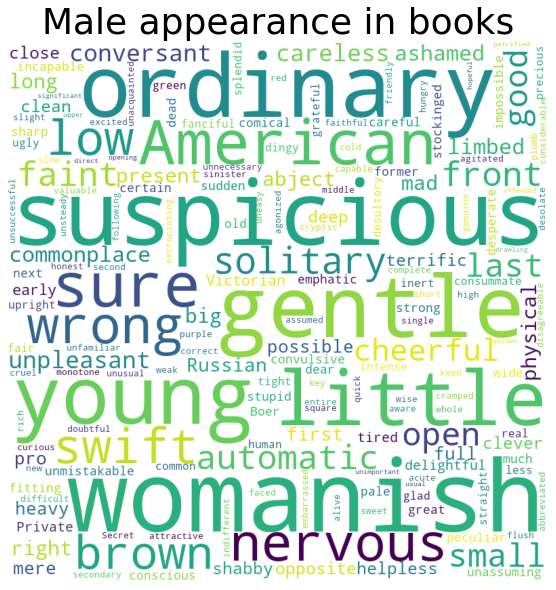

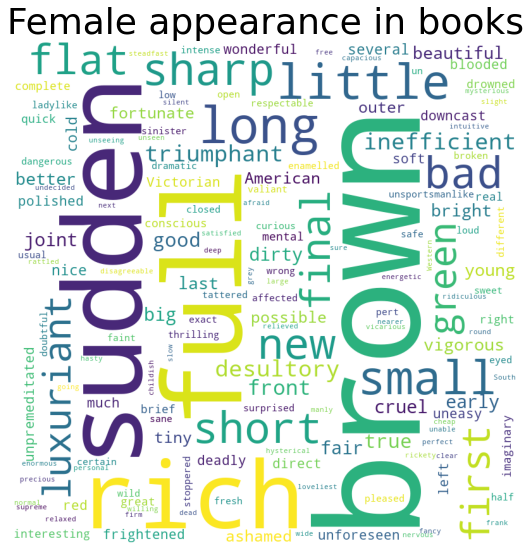

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image
from os import path
import matplotlib.pyplot as plt

male_adjective_list = []
female_adjective_list = []
male_verification = lambda x: maleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
female_verification = lambda x: femaleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
# Get adjectives for pronoun or possessive pronoun
for sentence in sentences:
  for triple in sentence.openieTriple:
    # (sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') and (sentences[subject.sentenceIndex].token[subject.tokenIndex].value in male_characters or sentences[subject.sentenceIndex].token[subject.tokenIndex].value in female_characters
    if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('PRP') for subject in triple.subjectTokens):
      male_verification_list = list(filter(male_verification, triple.subjectTokens))
      female_verification_list = list(filter(female_verification, triple.subjectTokens))
      if len(male_verification_list) > 0:
        for obj in triple.objectTokens:
          if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('JJ'):
            male_adjective_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
        continue
      elif len(female_verification_list) > 0:
        for obj in triple.objectTokens:
          if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('JJ'):
            female_adjective_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
        continue
# Get adjectives for proper noun
for sentence in sentences:
  for triple in sentence.openieTriple:
    if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') for subject in triple.subjectTokens):
      # print(triple.subjectTokens[0].sentenceIndex, triple.subjectTokens[-1].sentenceIndex)
      tokens = [sentences[x.sentenceIndex].token[x.tokenIndex].value for x in triple.subjectTokens]
      subject = ' '.join(tokens)
      if subject in male_characters:
        for obj in triple.objectTokens:
          if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('JJ'):
            male_adjective_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
        continue
      elif subject in female_characters:
        for obj in triple.objectTokens:
          if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('JJ'):
            female_adjective_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
        continue

wordcloud = WordCloud(width = 800, height = 800,
                background_color = 'white',
                collocations = False,
                min_font_size = 10).generate(' '.join(male_adjective_list))

print(male_adjective_list)
print(female_adjective_list)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.title('Male appearance in books', fontsize = 36)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
 
plt.show()

wordcloud = WordCloud(width = 800, height = 800,
                      background_color = 'white',
                      collocations = False,
                      min_font_size = 10).generate(' '.join(female_adjective_list))

plt.figure(figsize = (8, 8), facecolor = None)
plt.title('Female appearance in books', fontsize = 36)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
 
plt.show()

# Como personagens de cada gênero são representados

['quick', 'nervous', 'nervous', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'suspicious', 'swift', 'suspicious', 'suspicious', 'suspicious', 'nervous', 'suspicious', 'nervous', 'suspicious', 'nervous', 'swift', 'suspicious', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'suspicious', 'swift', 'suspicious', 'agitated', 'agitated', 'red', 'red', 'ugly', 'ugly', 'young', 'early', 'Victorian', 'delightful', 'Victorian', 'delightful', 'early', 'delightful', 'early', 'Victorian', 'delightful', 'early', 'Victorian', 'deeper', 'last', 'heavy', 'heavy', 'big', 'small', 'Private', 'Private', 'like', 'like', 'fullest', 'more', 'other', 'good', 'other', 'good', 'attractive', 'attractive', 'tired', 'tired', 'little', 'little', 'unusual', 'unusual', 'other', 'other', 'Secret', 'monotone', 'Secret', 'low', 'monotone', 'precious', 'possible', 'unassuming', 'unassuming', 'un

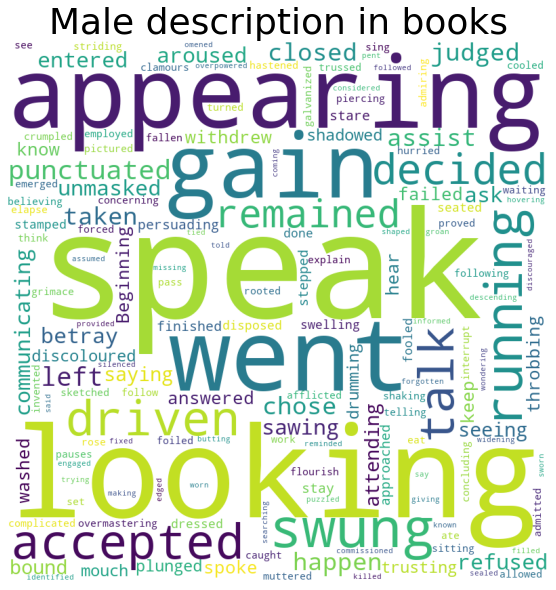

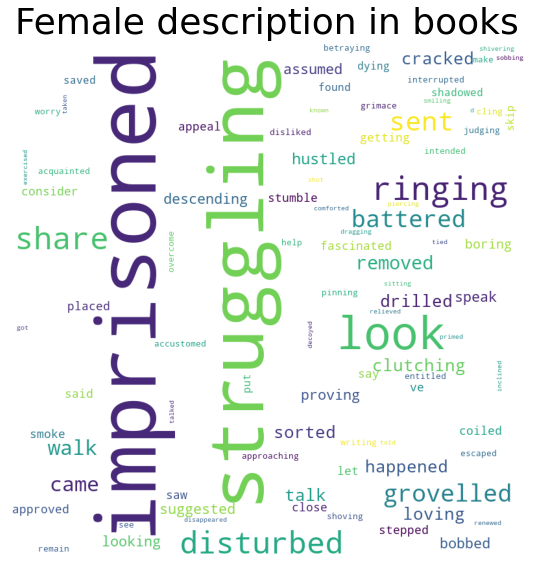

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image
from os import path
import matplotlib.pyplot as plt

male_verb_list = []
female_verb_list = []
male_verification = lambda x: maleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
female_verification = lambda x: femaleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
# Get adjectives for pronoun or possessive pronoun
for sentence in sentences:
  for triple in sentence.openieTriple:
    # (sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') and (sentences[subject.sentenceIndex].token[subject.tokenIndex].value in male_characters or sentences[subject.sentenceIndex].token[subject.tokenIndex].value in female_characters
    if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('PRP') for subject in triple.subjectTokens):
      male_verification_list = list(filter(male_verification, triple.subjectTokens))
      female_verification_list = list(filter(female_verification, triple.subjectTokens))
      if len(male_verification_list) > 0:
        for obj in triple.objectTokens:
          if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('VB'):
            male_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
        continue
      elif len(female_verification_list) > 0:
        for obj in triple.objectTokens:
          if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('VB'):
            female_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
        continue
# Get adjectives for proper noun
for sentence in sentences:
  for triple in sentence.openieTriple:
    if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') for subject in triple.subjectTokens):
      # print(triple.subjectTokens[0].sentenceIndex, triple.subjectTokens[-1].sentenceIndex)
      tokens = [sentences[x.sentenceIndex].token[x.tokenIndex].value for x in triple.subjectTokens]
      subject = ' '.join(tokens)
      if subject in male_characters:
        for obj in triple.objectTokens:
          if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('VB'):
            male_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
        continue
      elif subject in female_characters:
        for obj in triple.objectTokens:
          if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('VB'):
            female_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
        continue

wordcloud = WordCloud(width = 800, height = 800,
                background_color = 'white',
                collocations = False,
                min_font_size = 10).generate(' '.join(male_verb_list))

print(male_adjective_list)
print(female_adjective_list)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.title('Male description in books', fontsize = 36)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
 
plt.show()

wordcloud = WordCloud(width = 800, height = 800,
                      background_color = 'white',
                      collocations = False,
                      min_font_size = 10).generate(' '.join(female_verb_list))

plt.figure(figsize = (8, 8), facecolor = None)
plt.title('Female description in books', fontsize = 36)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
 
plt.show()

# Exploração de montagem de lista de profissões utilizando o wordnet
Utilizando lista de hipônimos para algumas palavras chaves para essa construção.

In [ ]:
import re
import nltk
nltk.download('wordnet')
nltk.download('wordnet31')
nltk.download('omw-1.4')
nltk.download('brown')
from nltk.corpus import brown
from nltk.corpus import wordnet as wn

profession_expression = re.compile(r'Profession|position|occupation|line of work|employment|occupancy|work|role|labor|industry|job', re.IGNORECASE)

def get_hyponyms(synset, hyponyms = set()):
  for hyponym in synset.hyponyms():
    hyponyms |= set(synset.closure(lambda s: s.hyponyms()))
    hyponyms |= get_hyponyms(hyponym, hyponyms)
  return hyponyms | set(synset.closure(lambda s: s.hyponyms()))

def filter_occupations(set_data):
  return set(filter(lambda x: profession_expression.search(x.definition()), set_data))

work = wn.synsets('work')
job = wn.synsets('job')
occupation = wn.synset('occupation.n.01')
profession1 = wn.synset('profession.n.01')
profession2 = wn.synset('profession.n.02')

print(work)
print(job)

complete_list_professions = get_hyponyms(occupation).union(get_hyponyms(profession1), get_hyponyms(profession2))

for x in work:
  complete_list_professions = complete_list_professions.union(get_hyponyms(x))

for x in job:
  complete_list_professions = complete_list_professions.union(get_hyponyms(x))

print(complete_list_professions)

complete_list_professions = filter_occupations(complete_list_professions)

complete_list_professions = list(map(lambda x: x.lemma_names(), complete_list_professions))

complete_list_professions = [item for sublist in complete_list_professions for item in sublist]
complete_list_professions = list(map(lambda x: x.replace('_', ' '), complete_list_professions))

print(complete_list_professions)
print(len(complete_list_professions))

# data = []

# for o in list(filter_occupations(complete_list_professions)):
#   data += o.lemma_names()

# print(data)
# print(len(data))

# for p in list(get_hyponyms(occupation)):
#   p.
# print(get_hyponyms(profession1).union(get_hyponyms(profession2)))

# occupations = list(set([w for s in occupation.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))
# professions = list(set([w for s in profession1.closure(lambda s:s.hyponyms()) for w in s.lemma_names()])
#                     .union(set([w for s in profession2.closure(lambda s:s.hyponyms()) for w in s.lemma_names()])))

# print(occupations)
# print(professions)

# for syn in wn.synsets('occupation'):
#   print(syn.hyponyms())
# print(wn.synsets('profession'))
# for syn in wn.synsets('profession'):
#   print(syn.hyponyms())

#print(wn.synsets('prostitute'))

from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image
from os import path
import matplotlib.pyplot as plt

male_occupation_list = []
female_occupation_list = []
male_verification = lambda x: maleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
female_verification = lambda x: femaleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
# Get occupation for pronoun or possessive pronoun
for sentence in sentences:
  for triple in sentence.openieTriple:
    # (sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') and (sentences[subject.sentenceIndex].token[subject.tokenIndex].value in male_characters or sentences[subject.sentenceIndex].token[subject.tokenIndex].value in female_characters
    if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('PRP') for subject in triple.subjectTokens):
      male_verification_list = list(filter(male_verification, triple.subjectTokens))
      female_verification_list = list(filter(female_verification, triple.subjectTokens))
      if len(male_verification_list) > 0:
        for obj in triple.objectTokens:
          if sentences[obj.sentenceIndex].token[obj.tokenIndex].value in complete_list_professions:
            male_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
        continue
      elif len(female_verification_list) > 0:
        for obj in triple.objectTokens:
          if sentences[obj.sentenceIndex].token[obj.tokenIndex].value in complete_list_professions:
            female_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
        continue
# Get professions for proper noun
for sentence in sentences:
  for triple in sentence.openieTriple:
    if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') for subject in triple.subjectTokens):
      # print(triple.subjectTokens[0].sentenceIndex, triple.subjectTokens[-1].sentenceIndex)
      tokens = [sentences[x.sentenceIndex].token[x.tokenIndex].value for x in triple.subjectTokens]
      subject = ' '.join(tokens)
      if subject in male_characters:
        for obj in triple.objectTokens:
          if sentences[obj.sentenceIndex].token[obj.tokenIndex].value in complete_list_professions:
            male_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
        continue
      elif subject in female_characters:
        for obj in triple.objectTokens:
          if sentences[obj.sentenceIndex].token[obj.tokenIndex].value in complete_list_professions:
            female_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
        continue

print(male_occupation_list)
print(female_occupation_list)

if len(male_occupation_list) > 0:
  wordcloud = WordCloud(width = 800, height = 800,
                        background_color = 'white',
                        collocations = False,
                        min_font_size = 10).generate(' '.join(male_occupation_list))
  # plot the WordCloud image                      
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.title('Male occupation in books', fontsize = 36)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.tight_layout(pad = 0)
  
  plt.show()


if len(female_occupation_list) > 0:
  wordcloud = WordCloud(width = 800, height = 800,
                        background_color = 'white',
                        collocations = False,
                        min_font_size = 10).generate(' '.join(female_occupation_list))

  plt.figure(figsize = (8, 8), facecolor = None)
  plt.title('Female occupation in books', fontsize = 36)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.tight_layout(pad = 0)
  
  plt.show()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet31 to /root/nltk_data...
[nltk_data]   Package wordnet31 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


[Synset('work.n.01'), Synset('work.n.02'), Synset('employment.n.02'), Synset('study.n.02'), Synset('work.n.05'), Synset('workplace.n.01'), Synset('oeuvre.n.01'), Synset('work.v.01'), Synset('work.v.02'), Synset('work.v.03'), Synset('function.v.01'), Synset('work.v.05'), Synset('exercise.v.03'), Synset('make.v.36'), Synset('work.v.08'), Synset('work.v.09'), Synset('work.v.10'), Synset('bring.v.03'), Synset('work.v.12'), Synset('cultivate.v.02'), Synset('work.v.14'), Synset('influence.v.01'), Synset('work.v.16'), Synset('work.v.17'), Synset('work.v.18'), Synset('work.v.19'), Synset('shape.v.02'), Synset('work.v.21'), Synset('knead.v.01'), Synset('exploit.v.01'), Synset('solve.v.01'), Synset('ferment.v.03'), Synset('sour.v.01'), Synset('work.v.27')]
[Synset('occupation.n.01'), Synset('job.n.02'), Synset('job.n.03'), Synset('job.n.04'), Synset('job.n.05'), Synset('job.n.06'), Synset('job.n.07'), Synset('problem.n.01'), Synset('job.n.09'), Synset('job.n.10'), Synset('job.n.11'), Synset('job

# Pickle dados para manipulação futura

In [ ]:
!cp drive/MyDrive/TCC/classes.py .

In [ ]:
import pickle
# import classes

RESULTS_HOME = '/content/drive/MyDrive/TCC/results'

data = AnalysisResult(chosen_fiction_books_list[3])
data.adjectives[Gender.MALE] = male_adjective_list
data.adjectives[Gender.FEMALE] = female_adjective_list
data.verbs[Gender.MALE] = male_verb_list
data.verbs[Gender.FEMALE] = female_verb_list
data.occupations[Gender.MALE] = male_occupation_list
data.occupations[Gender.FEMALE] = female_occupation_list
data.mentions[Gender.MALE] = maleMentions
data.mentions[Gender.FEMALE] = femaleMentions

print(data.adjectives[Gender.MALE])
print(data.adjectives[Gender.FEMALE])
print(re.sub('txt', 'pickle', data.book.filename))

with open(f"{RESULTS_HOME}/{re.sub('txt', 'pickle', data.book.filename)}", 'wb') as f:
  pickle.dump(data, f)

objdump = None
 
with open(f"{RESULTS_HOME}/{re.sub('txt', 'pickle', data.book.filename)}", 'rb') as f:
    # Stores the now deserialized information into objdump
    objdump = pickle.load(f)

print(objdump.adjectives[Gender.MALE])
print(objdump.adjectives[Gender.FEMALE])
print(objdump.verbs[Gender.MALE])
print(objdump.verbs[Gender.FEMALE])
print(objdump.occupations[Gender.MALE])
print(objdump.occupations[Gender.FEMALE])
print(objdump.mentions[Gender.MALE])
print(objdump.mentions[Gender.FEMALE])
print(objdump.book.filename)



['quick', 'nervous', 'nervous', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'suspicious', 'swift', 'suspicious', 'suspicious', 'suspicious', 'nervous', 'suspicious', 'nervous', 'suspicious', 'nervous', 'swift', 'suspicious', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'suspicious', 'swift', 'suspicious', 'agitated', 'agitated', 'red', 'red', 'ugly', 'ugly', 'young', 'early', 'Victorian', 'delightful', 'Victorian', 'delightful', 'early', 'delightful', 'early', 'Victorian', 'delightful', 'early', 'Victorian', 'deeper', 'last', 'heavy', 'heavy', 'big', 'small', 'Private', 'Private', 'like', 'like', 'fullest', 'more', 'other', 'good', 'other', 'good', 'attractive', 'attractive', 'tired', 'tired', 'little', 'little', 'unusual', 'unusual', 'other', 'other', 'Secret', 'monotone', 'Secret', 'low', 'monotone', 'precious', 'possible', 'unassuming', 'unassuming', 'un

# Verificar se o client CoreNLP java, invocado pelo Stanza, está em execução

In [ ]:
!ps -o pid,cmd | grep java
!ls $CORENLP_HOME

    457 /bin/bash -c ps -o pid,cmd | grep java
    459 grep java
build.xml				  LIBRARY-LICENSES
corenlp.sh				  LICENSE.txt
CoreNLP-to-HTML.xsl			  Makefile
ejml-core-0.39.jar			  patterns
ejml-core-0.39-sources.jar		  pom-java-11.xml
ejml-ddense-0.39.jar			  pom-java-17.xml
ejml-ddense-0.39-sources.jar		  pom.xml
ejml-simple-0.39.jar			  protobuf-java-3.19.2.jar
ejml-simple-0.39-sources.jar		  README.txt
input.txt				  RESOURCE-LICENSES
input.txt.out				  sample-project-pom.xml
input.txt.xml				  SemgrexDemo.java
istack-commons-runtime-3.0.7.jar	  ShiftReduceDemo.java
istack-commons-runtime-3.0.7-sources.jar  slf4j-api.jar
javax.activation-api-1.2.0.jar		  slf4j-simple.jar
javax.activation-api-1.2.0-sources.jar	  stanford-corenlp-4.5.1.jar
javax.json-api-1.0-sources.jar		  stanford-corenlp-4.5.1-javadoc.jar
javax.json.jar				  stanford-corenlp-4.5.1-models.jar
jaxb-api-2.4.0-b180830.0359.jar		  stanford-corenlp-4.5.1-sources.jar
jaxb-api-2.4.0-b180830.0359-sources.jar   StanfordCoreN

In [ ]:
# Iterate over all detected entity mentions
print("{:30s}\t{}".format("Mention", "Type"))

for sent in ann.sentence:
    for m in sent.mentions:
        print("{:30s}\t{}".format(m.entityMentionText, m.entityType))

A saída de streaming foi truncada nas últimas 5000 linhas.
Priscilla                     	PERSON
prophet                       	TITLE
his                           	PERSON
Barbecue-Smith                	PERSON
ten                           	NUMBER
eight                         	NUMBER
He                            	PERSON
he                            	PERSON
he                            	PERSON
his                           	PERSON
He                            	PERSON
One                           	NUMBER
Denis                         	PERSON
he                            	PERSON
Barbecue-Smith                	PERSON
Denis                         	PERSON
Barbecue-Smith                	PERSON
last winter                   	DATE
fires                         	CAUSE_OF_DEATH
his                           	PERSON
He                            	PERSON
his                           	PERSON
Denis                         	PERSON
he                            	PERSON
he                      

# Monta CSV com a lista de todos os livros presente na base, separando-os em um par de nome e título.

In [ ]:
import csv
import os

# fileList = os.listdir('/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/fiction')
fileList = os.listdir('/content/drive/MyDrive/TCC/unprocessed')
authorBookList = map(lambda file: file.rstrip('.txt').split('___', 1), fileList)
with open(os.getcwd() + '/unprocessed.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Autor', 'Título'])
    for pair in authorBookList:
        writer.writerow(pair)

# Versão chamando Gender API
Não será possível seguir com essa estratégia, pois o gender-api possui um limite de 500 requisições por mês e, mesmo agrupando todos os personagens e motando um hashset ou map deles, com certeza, considerando a quantidade de livros, ultrapassaria o limite mensal.

In [ ]:
import json
import requests

# TODO: Consider using coref to get genders of tokens identified with NER as person
# or use genderAPI to determine this, maybe try both methods and compile results as reference.
# Não será possível, pois a limitação de créditos mensal pela Gender API não permite isso.
# Fora o gasto por recurso. Para minimizar isso (requisições e gasto de créditos),
# seria necessário criar um Map (ou hashset) Por nome do sujeito (chave) e quantidade de
# citações (valor) e, dependendo do resultado da api somar essa qtde de citações ao invés de somente 1
for sentence in sentences:
  for triple in sentence.openieTriple:
    if len(triple.tree.node) > 0:
      # print(triple.subject)
      # print(sentences[triple.subjectTokens[0].sentenceIndex].token[triple.subjectTokens[0].tokenIndex:triple.subjectTokens[-1].tokenIndex])
      if (any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos == 'NNP' for subject in triple.subjectTokens)):
        for su in triple.subjectTokens:
          token = sentences[su.sentenceIndex].token[su.tokenIndex]
          if token.ner == 'PERSON':
            response = requests.get(f'https://gender-api.com/get?name={token.value}&key=mcB8cKMMkjrC2B6TohZ2E7geWdoZVDPytoJs').json()
            if response['gender'].upper() == 'MALE':
              maleMentions += 1
            elif response['gender'].upper() == 'FEMALE':
              femaleMentions += 1
      # TODO: find an article that gives an appropriate confidence rating
      # read https://nlp.stanford.edu/pubs/2015angeli-openie.pdf
      # print(triple.subjectTokens)
print(f'Number of male mentions {maleMentions}')
print(f'Number of female mentions {femaleMentions}')

KeyboardInterrupt: ignored

# Utilizando OpenLibrary API

In [ ]:
import json
import os
import pandas as pd
import requests
import re
from enum import Enum

def get_bio(api_response):
  if 'bio' in api_response:
    if 'value' in api_response['bio']:
      return api_response['bio']['value']
    elif type(api_response['bio']) is str:
      return api_response['bio']
  return ''

maleRegex = re.compile(r'\b(he|his|him)\b')
femaleRegex = re.compile(r'\b(her|she|hers)\b')
fileList = os.listdir('/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/fiction')
authorBookList = map(lambda file: file.rstrip('.txt').split('___', 1), fileList)
authors = {x[0]: x for x in authorBookList}.values()
distinctauthorlist = [Author(x[0]) for x in authors]

for author in distinctauthorlist:
  response = requests.get(f'https://openlibrary.org/search/authors.json?q={author.name}').json()
  #print(response)
  if response['numFound'] > 1:
    for r in response['docs']:
      bio = get_bio(requests.get(f'https://openlibrary.org/authors/{r["key"]}.json').json())
      author.add_gender(Gender.UNKNOWN)
      if maleRegex.search(bio):
        author.add_gender(Gender.MALE)
        break
      elif femaleRegex.search(bio):
        author.add_gender(Gender.FEMALE)
        break
  elif response['numFound'] == 1:
    bio = get_bio(requests.get(f'https://openlibrary.org/authors/{response["docs"].pop()["key"]}.json').json())
    author.add_gender(Gender.UNKNOWN)
    if maleRegex.search(bio):
      author.add_gender(Gender.MALE)
    elif femaleRegex.search(bio):
      author.add_gender(Gender.FEMALE)

authorsWithGender = 0;
for author in distinctauthorlist:
  if (author.gender == 'M' or author.gender == 'F'):
    authorsWithGender += 1
  print(f'{author.name} - {author.gender}')

print(f'Total authors {len(distinctauthorlist)}')
print(f'Number of categorized authors {authorsWithGender}')
print(f'Number of uncategorized authors {len(distinctauthorlist) - authorsWithGender}')
print(f'Percentage of categorized authors {(authorsWithGender / len(distinctauthorlist)) * 100}%')


KeyboardInterrupt: ignored

# Utilizando Gender API para determinar o sexo do Autor

In [ ]:
import json
import os
import pandas as pd
import requests
import re
from enum import Enum

fileList = os.listdir('/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/fiction')
authorBookList = map(lambda file: file.rstrip('.txt').split('___', 1), fileList)
authors = {x[0]: x for x in authorBookList}.values()
distinctauthorlist = [Author(x[0]) for x in authors]

for author in distinctauthorlist:
  response = requests.get(f'https://gender-api.com/get?name={author.name}&key=ZoUzmKylBFxN6ww5T62G9DNfYQzVr9WRLLMt').json()
  author.add_gender(Gender[response['gender'].upper()])

authorsWithGender = 0
femaleAuthors = 0
maleAuthors = 0

for author in distinctauthorlist:
  if (author.gender == 'M' or author.gender == 'F'):
    authorsWithGender += 1
    if (author.gender == 'F'):
      femaleAuthors += 1;
    else:
      maleAuthors += 1;
  print(f'{author.name} - {author.gender}')

print(f'Total authors {len(distinctauthorlist)}')
print(f'Number of categorized authors {authorsWithGender}')
print(f'Number of uncategorized authors {len(distinctauthorlist) - authorsWithGender}')
print(f'Number of male authors {maleAuthors}')
print(f'Number of female authors {femaleAuthors}')
print(f'Percentage of categorized authors {(authorsWithGender / len(distinctauthorlist)) * 100}%')

Philip Kindred Dick - M
Rafael Sabatini - M
R M Ballantyne - M
Robert Louis Stevenson - M
Rudyard Kipling - M
Sinclair Lewis - M
Sir Arthur Conan Doyle - M
Sir Walter Scott - M
Stephen Leacock - M
Thomas Carlyle - M
Thomas Hardy - M
Thornton Waldo Burgess - M
Virginia Woolf - F
Washington Irving - M
Walter de la Mare - M
Wilkie Collins - M
William Dean Howells - M
William Makepeace Thackeray - M
William Somerset Maugham - M
Winston Churchill - M
Zane Grey - M
Harold Bindloss - M
Henry James - M
Henry Rider Haggard - M
Herbert George Wells - M
Herman Melville - M
Howard Pyle - M
Jack London - M
Isaac Asimov - M
Jacob Abbott - M
James Fenimore Cooper - M
James Joyce - M
James Matthew Barrie - M
James Otis - M
Jane Austen - F
John Bunyan - M
John Galsworthy - M
John Keats - M
Joseph Conrad - M
Lewis Carroll - M
Louisa May Alcott - F
Lucy Maud Montgomery - F
Mark Twain - M
Lyman Frank Baum - M
Mary Shelley - F
Nathaniel Hawthorne - M
Mary Stewart Daggett - F
O Henry - M
Oscar Wilde - M
And

# Keep Colab Running

In [ ]:
function ClickConnect(){
var reconnect = document.querySelector("colab-toolbar-button#connect")
if(reconnect != null){
console.log("working")
reconnect.click()
}
}
const tensorInterval = setInterval(ClickConnect,60000)
// Then to stop clicking paste this
// clearInterval(tensorInterval)